# libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import MessagePassing, GCNConv
from torch_scatter import scatter_mean
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from datetime import datetime

/opt/anaconda3/envs/dsa4288/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("MPS is available, using MPS for computations!")
else:
    device = torch.device('cpu')
    print("MPS not available, using CPU instead.")

MPS is available, using MPS for computations!


In [3]:
# set seed
seed=4288
random.seed(seed)  # Python random module
np.random.seed(seed)  # NumPy
torch.manual_seed(seed)  # PyTorch (CPU & MPS)

# data, features and data normalisation

In [4]:
fraud_train = pd.read_csv('data/fraudTrain.csv')
fraud_test = pd.read_csv('data/fraudTest.csv')
transaction_counts = pd.read_csv('transaction_counts.csv') # preprocessed data, containing count of transactions 
                                                           # per customer over the last 24 hours, 7 days, 30 days
past_freq_with_merchant = pd.read_csv('past_count_with_merchant.csv') # preprocessed data, containing count of transactions
                                                                      # made between customer and merchant historically for each transaction

In [5]:
# Perform left join
fraud_train = fraud_train.merge(transaction_counts[['trans_num', 'count_last24h', 'count_last7days', 'count_last30days']], 
                                on='trans_num', how='left')
fraud_test = fraud_test.merge(transaction_counts[['trans_num', 'count_last24h', 'count_last7days', 'count_last30days']], 
                              on='trans_num', how='left')

fraud_train = fraud_train.merge(past_freq_with_merchant, on='trans_num', how='left')
fraud_test = fraud_test.merge(past_freq_with_merchant, on='trans_num', how='left')


fraud_train['is_test'] = 0
fraud_test['is_test'] = 1

In [6]:
def haversine(lat1, long1, lat2, long2):
    """computes haversine distance between a pair of coordinates"""
    R = 6371  # Radius of the Earth in kilometers
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(long2 - long1)
    
    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c  # Distance in kilometers

fraud_train["distance"] = fraud_train.apply(lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"]), axis=1)
fraud_test["distance"] = fraud_test.apply(lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"]), axis=1)

In [7]:
fraud_train['gender_binary'] = fraud_train['gender'].map({'M': 1.0, 'F': 0.0})
fraud_test['gender_binary'] = fraud_test['gender'].map({'M': 1.0, 'F': 0.0})

In [8]:
# Convert trans_date_trans_time to datetime if not already done
fraud_train['trans_date_trans_time'] = pd.to_datetime(fraud_train['trans_date_trans_time'])
fraud_test['trans_date_trans_time'] = pd.to_datetime(fraud_test['trans_date_trans_time'])

# Extract the date component
fraud_train['trans_date'] = fraud_train['trans_date_trans_time'].dt.date
fraud_test['trans_date'] = fraud_test['trans_date_trans_time'].dt.date

fraud_train['week'] = fraud_train['trans_date_trans_time'].dt.isocalendar().week
fraud_train['day_of_week'] = fraud_train['trans_date_trans_time'].dt.day_name()
fraud_test['week'] = fraud_test['trans_date_trans_time'].dt.isocalendar().week
fraud_test['day_of_week'] = fraud_test['trans_date_trans_time'].dt.day_name()

# Convert day_of_week to numerical values (Monday=1, ..., Sunday=7)
fraud_train['day_of_week'] = fraud_train['day_of_week'].map({
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7
})
fraud_test['day_of_week'] = fraud_test['day_of_week'].map({
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7
})

fraud_train['trans_hour'] = fraud_train['trans_date_trans_time'].dt.hour
fraud_test['trans_hour'] = fraud_test['trans_date_trans_time'].dt.hour

def get_age(dob, trans_date):
    """Calculate age based on date of birth and transaction date."""
    dob = datetime.strptime(dob, '%Y-%m-%d')  # dob is in 'YYYY-MM-DD' format
    trans_date = trans_date #datetime.strptime(row['trans_date_trans_time'], '%Y-%m-%d %H:%M:%S')
    return float(trans_date.year - dob.year)

fraud_train['age'] = fraud_train.apply(lambda row: get_age(row['dob'], row['trans_date']), axis=1)
fraud_test['age'] = fraud_test.apply(lambda row: get_age(row['dob'], row['trans_date']), axis=1)

In [9]:
# is_late_night binary column (trans_hour=22-3)
fraud_train['is_late_night'] = fraud_train['trans_hour'].apply(lambda x: 1.0 if x <= 3 or x >= 22 else 0.0)
fraud_test['is_late_night'] = fraud_test['trans_hour'].apply(lambda x: 1.0 if x <= 3 or x >= 22 else 0.0)

# cyclical encoding for hour and day of week

fraud_train['hour_sin'] = np.sin(2 * np.pi * fraud_train['trans_hour'] / 24)
fraud_train['hour_cos'] = np.cos(2 * np.pi * fraud_train['trans_hour'] / 24)
fraud_test['hour_sin'] = np.sin(2 * np.pi * fraud_test['trans_hour'] / 24)
fraud_test['hour_cos'] = np.cos(2 * np.pi * fraud_test['trans_hour'] / 24)

fraud_train['day_sin'] = np.sin(2 * np.pi * fraud_train['day_of_week'] / 7)
fraud_train['day_cos'] = np.cos(2 * np.pi * fraud_train['day_of_week'] / 7)
fraud_test['day_sin'] = np.sin(2 * np.pi * fraud_test['day_of_week'] / 7)
fraud_test['day_cos'] = np.cos(2 * np.pi * fraud_test['day_of_week'] / 7)

In [10]:
unique_train_jobs = set(fraud_train['job'].unique())
unique_test_jobs = set(fraud_test['job'].unique())
unique_jobs = unique_train_jobs | unique_test_jobs

job_categories = ["Education & Training", "Healthcare & Medicine", "Engineering", "Technology & IT", "Science & Research", 
                  "Creative Arts & Design", "Legal & Law Enforcement", "Business & Finance", "Environment & Agriculture", 
                  "Government & Public Services", "Social Services & Non-Profit", "Media & Communications", "Hospitality, Tourism & Events"]

# Create a dictionary to map unique jobs to job categories
job_category_mapping = {
    'Psychologist, counselling': 'Healthcare & Medicine',
    'Special educational needs teacher': 'Education & Training',
    'Nature conservation officer': 'Environment & Agriculture',
    'Patent attorney': 'Legal & Law Enforcement',
    'Dance movement psychotherapist': 'Healthcare & Medicine',
    'Transport planner': 'Engineering',
    'Arboriculturist': 'Environment & Agriculture',
    'Designer, multimedia': 'Creative Arts & Design',
    'Public affairs consultant': 'Government & Public Services',
    'Pathologist': 'Healthcare & Medicine',
    'IT trainer': 'Technology & IT',
    'Systems developer': 'Technology & IT',
    'Engineer, land': 'Engineering',
    'Systems analyst': 'Technology & IT',
    'Naval architect': 'Engineering',
    'Radiographer, diagnostic': 'Healthcare & Medicine',
    'Programme researcher, broadcasting/film/video': 'Media & Communications',
    'Energy engineer': 'Engineering',
    'Event organiser': 'Hospitality, Tourism & Events',
    'Operational researcher': 'Science & Research',
    'Market researcher': 'Business & Finance',
    'Probation officer': 'Social Services & Non-Profit',
    'Leisure centre manager': 'Hospitality, Tourism & Events',
    'Corporate investment banker': 'Business & Finance',
    'Therapist, occupational': 'Healthcare & Medicine',
    'Call centre manager': 'Business & Finance',
    'Police officer': 'Legal & Law Enforcement',
    'Education officer, museum': 'Education & Training',
    'Physiotherapist': 'Healthcare & Medicine',
    'Network engineer': 'Technology & IT',
    'Forensic psychologist': 'Healthcare & Medicine',
    'Geochemist': 'Science & Research',
    'Armed forces training and education officer': 'Education & Training',
    'Designer, furniture': 'Creative Arts & Design',
    'Optician, dispensing': 'Healthcare & Medicine',
    'Psychologist, forensic': 'Healthcare & Medicine',
    'Librarian, public': 'Education & Training',
    'Fine artist': 'Creative Arts & Design',
    'Scientist, research (maths)': 'Science & Research',
    'Research officer, trade union': 'Government & Public Services',
    'Tourism officer': 'Hospitality, Tourism & Events',
    'Human resources officer': 'Business & Finance',
    'Surveyor, minerals': 'Environment & Agriculture',
    'Applications developer': 'Technology & IT',
    'Video editor': 'Media & Communications',
    'Curator': 'Creative Arts & Design',
    'Research officer, political party': 'Government & Public Services',
    'Engineer, mining': 'Engineering',
    'Education officer, community': 'Education & Training',
    'Physicist, medical': 'Science & Research',
    'Amenity horticulturist': 'Environment & Agriculture',
    'Electrical engineer': 'Engineering',
    'Television camera operator': 'Media & Communications',
    'Higher education careers adviser': 'Education & Training',
    'Ambulance person': 'Healthcare & Medicine',
    'Dealer': 'Business & Finance',
    'Paediatric nurse': 'Healthcare & Medicine',
    'Trading standards officer': 'Legal & Law Enforcement',
    'Engineer, technical sales': 'Engineering',
    'Designer, jewellery': 'Creative Arts & Design',
    'Clinical biochemist': 'Science & Research',
    'Engineer, electronics': 'Engineering',
    'Water engineer': 'Engineering',
    'Science writer': 'Media & Communications',
    'Film/video editor': 'Media & Communications',
    'Solicitor, Scotland': 'Legal & Law Enforcement',
    'Product/process development scientist': 'Science & Research',
    'Tree surgeon': 'Environment & Agriculture',
    'Careers information officer': 'Education & Training',
    'Geologist, engineering': 'Science & Research',
    'Counsellor': 'Social Services & Non-Profit',
    'Freight forwarder': 'Business & Finance',
    'Senior tax professional/tax inspector': 'Government & Public Services',
    'Engineer, broadcasting (operations)': 'Engineering',
    'English as a second language teacher': 'Education & Training',
    'Economist': 'Business & Finance',
    'Child psychotherapist': 'Healthcare & Medicine',
    'Claims inspector/assessor': 'Business & Finance',
    'Tourist information centre manager': 'Hospitality, Tourism & Events',
    'Exhibitions officer, museum/gallery': 'Creative Arts & Design',
    'Location manager': 'Media & Communications',
    'Engineer, biomedical': 'Engineering',
    'Research scientist (physical sciences)': 'Science & Research',
    'Purchasing manager': 'Business & Finance',
    'Editor, magazine features': 'Media & Communications',
    'Operations geologist': 'Science & Research',
    'Interpreter': 'Social Services & Non-Profit',
    'Engineering geologist': 'Science & Research',
    'Agricultural consultant': 'Environment & Agriculture',
    'Paramedic': 'Healthcare & Medicine',
    'Financial adviser': 'Business & Finance',
    'Administrator, education': 'Education & Training',
    'Educational psychologist': 'Education & Training',
    'Financial trader': 'Business & Finance',
    'Audiological scientist': 'Science & Research',
    'Scientist, audiological': 'Science & Research',
    'Administrator, charities/voluntary organisations': 'Social Services & Non-Profit',
    'Health service manager': 'Healthcare & Medicine',
    'Retail merchandiser': 'Business & Finance',
    'Telecommunications researcher': 'Technology & IT',
    'Exercise physiologist': 'Healthcare & Medicine',
    'Accounting technician': 'Business & Finance',
    'Product designer': 'Creative Arts & Design',
    'Waste management officer': 'Environment & Agriculture',
    'Mining engineer': 'Engineering',
    'Surgeon': 'Healthcare & Medicine',
    'Therapist, horticultural': 'Environment & Agriculture',
    'Environmental consultant': 'Environment & Agriculture',
    'Broadcast presenter': 'Media & Communications',
    'Producer, radio': 'Media & Communications',
    'Engineer, communications': 'Engineering',
    'Historic buildings inspector/conservation officer': 'Environment & Agriculture',
    'Teacher, English as a foreign language': 'Education & Training',
    'Materials engineer': 'Engineering',
    'Health visitor': 'Healthcare & Medicine',
    'Medical secretary': 'Healthcare & Medicine',
    'Theatre director': 'Creative Arts & Design',
    'Technical brewer': 'Business & Finance',
    'Land/geomatics surveyor': 'Environment & Agriculture',
    'Engineer, structural': 'Engineering',
    'Diagnostic radiographer': 'Healthcare & Medicine',
    'Television production assistant': 'Media & Communications',
    'Medical sales representative': 'Business & Finance',
    'Building control surveyor': 'Engineering',
    'Therapist, sports': 'Healthcare & Medicine',
    'Structural engineer': 'Engineering',
    'Commercial/residential surveyor': 'Business & Finance',
    'Database administrator': 'Technology & IT',
    'Exhibition designer': 'Creative Arts & Design',
    'Training and development officer': 'Education & Training',
    'Mechanical engineer': 'Engineering',
    'Medical physicist': 'Science & Research',
    'Administrator': 'Government & Public Services',
    'Mudlogger': 'Engineering',
    'Fisheries officer': 'Environment & Agriculture',
    'Conservator, museum/gallery': 'Creative Arts & Design',
    'Programmer, multimedia': 'Technology & IT',
    'Cytogeneticist': 'Science & Research',
    'Multimedia programmer': 'Technology & IT',
    'Counselling psychologist': 'Healthcare & Medicine',
    'Chiropodist': 'Healthcare & Medicine',
    'Teacher, early years/pre': 'Education & Training',
    'Cartographer': 'Science & Research',
    'Pensions consultant': 'Business & Finance',
    'Primary school teacher': 'Education & Training',
    'Electronics engineer': 'Engineering',
    'Museum/gallery exhibitions officer': 'Creative Arts & Design',
    'Air broker': 'Business & Finance',
    'Chemical engineer': 'Engineering',
    'Advertising account executive': 'Business & Finance',
    'Advertising account planner': 'Business & Finance',
    'Chartered legal executive (England and Wales)': 'Legal & Law Enforcement',
    'Psychiatric nurse': 'Healthcare & Medicine',
    'Secondary school teacher': 'Education & Training',
    'Librarian, academic': 'Education & Training',
    'Embryologist, clinical': 'Science & Research',
    'Immunologist': 'Science & Research',
    'Television floor manager': 'Media & Communications',
    'Contractor': 'Business & Finance',
    'Health physicist': 'Science & Research',
    'Copy': 'Media & Communications',
    'Bookseller': 'Business & Finance',
    'Land': 'Environment & Agriculture',
    'Chartered loss adjuster': 'Business & Finance',
    'Occupational psychologist': 'Healthcare & Medicine',
    'Facilities manager': 'Business & Finance',
    'Further education lecturer': 'Education & Training',
    'Archivist': 'Education & Training',
    'Investment analyst': 'Business & Finance',
    'Engineer, building services': 'Engineering',
    'Psychologist, sport and exercise': 'Healthcare & Medicine',
    'Journalist, newspaper': 'Media & Communications',
    'Doctor, hospital': 'Healthcare & Medicine',
    'Phytotherapist': 'Healthcare & Medicine',
    'Pharmacologist': 'Science & Research',
    'Horticultural therapist': 'Environment & Agriculture',
    'Hydrologist': 'Science & Research',
    'Community arts worker': 'Creative Arts & Design',
    'Public house manager': 'Hospitality, Tourism & Events',
    'Architect': 'Creative Arts & Design',
    'Lexicographer': 'Education & Training',
    'Psychotherapist, child': 'Healthcare & Medicine',
    'Teacher, secondary school': 'Education & Training',
    'Toxicologist': 'Science & Research',
    'Commercial horticulturist': 'Environment & Agriculture',
    'Podiatrist': 'Healthcare & Medicine',
    'Building surveyor': 'Engineering',
    'Architectural technologist': 'Creative Arts & Design',
    'Editor, film/video': 'Media & Communications',
    'Social researcher': 'Social Services & Non-Profit',
    'Wellsite geologist': 'Science & Research',
    'Minerals surveyor': 'Environment & Agriculture',
    'Designer, ceramics/pottery': 'Creative Arts & Design',
    'Mental health nurse': 'Healthcare & Medicine',
    'Volunteer coordinator': 'Social Services & Non-Profit',
    'Chief Technology Officer': 'Technology & IT',
    'Camera operator': 'Media & Communications',
    'Copywriter, advertising': 'Media & Communications',
    'Surveyor, mining': 'Environment & Agriculture',
    'Product manager': 'Business & Finance',
    "Nurse, children's": 'Healthcare & Medicine',
    'Pension scheme manager': 'Business & Finance',
    'Archaeologist': 'Science & Research',
    'Sub': 'Media & Communications',
    'Designer, interior/spatial': 'Creative Arts & Design',
    'Futures trader': 'Business & Finance',
    'Chief Financial Officer': 'Business & Finance',
    'Museum education officer': 'Education & Training',
    'Quantity surveyor': 'Engineering',
    'Physiological scientist': 'Science & Research',
    'Loss adjuster, chartered': 'Business & Finance',
    'Pilot, airline': 'Hospitality, Tourism & Events',
    'Production assistant, radio': 'Media & Communications',
    'Immigration officer': 'Legal & Law Enforcement',
    'Retail banker': 'Business & Finance',
    'Health and safety adviser': 'Business & Finance',
    'Teacher, special educational needs': 'Education & Training',
    'Jewellery designer': 'Creative Arts & Design',
    'Community pharmacist': 'Healthcare & Medicine',
    'Control and instrumentation engineer': 'Engineering',
    'Make': 'Creative Arts & Design',
    'Early years teacher': 'Education & Training',
    'Sales professional, IT': 'Business & Finance',
    'Scientist, marine': 'Science & Research',
    'Intelligence analyst': 'Government & Public Services',
    'Clinical research associate': 'Science & Research',
    'Administrator, local government': 'Government & Public Services',
    'Barrister': 'Legal & Law Enforcement',
    'Engineer, control and instrumentation': 'Engineering',
    'Clothing/textile technologist': 'Creative Arts & Design',
    'Development worker, community': 'Social Services & Non-Profit',
    'Art therapist': 'Healthcare & Medicine',
    'Sales executive': 'Business & Finance',
    'Armed forces logistics/support/administrative officer': 'Government & Public Services',
    'Optometrist': 'Healthcare & Medicine',
    'Insurance underwriter': 'Business & Finance',
    'Charity officer': 'Social Services & Non-Profit',
    'Civil Service fast streamer': 'Government & Public Services',
    'Retail buyer': 'Business & Finance',
    'Magazine features editor': 'Media & Communications',
    'Equities trader': 'Business & Finance',
    'Trade mark attorney': 'Legal & Law Enforcement',
    'Research scientist (life sciences)': 'Science & Research',
    'Psychotherapist': 'Healthcare & Medicine',
    'Pharmacist, community': 'Healthcare & Medicine',
    'Risk analyst': 'Business & Finance',
    'Engineer, maintenance': 'Engineering',
    'Logistics and distribution manager': 'Business & Finance',
    'Water quality scientist': 'Environment & Agriculture',
    'Lecturer, further education': 'Education & Training',
    'Production assistant, television': 'Media & Communications',
    'Tour manager': 'Hospitality, Tourism & Events',
    'Music therapist': 'Healthcare & Medicine',
    'Surveyor, land/geomatics': 'Environment & Agriculture',
    'Engineer, production': 'Engineering',
    'Acupuncturist': 'Healthcare & Medicine',
    'Hospital doctor': 'Healthcare & Medicine',
    'Teacher, primary school': 'Education & Training',
    'Accountant, chartered public finance': 'Business & Finance',
    'Illustrator': 'Creative Arts & Design',
    'Scientist, physiological': 'Science & Research',
    'Buyer, industrial': 'Business & Finance',
    'Scientist, research (physical sciences)': 'Science & Research',
    'Radio producer': 'Media & Communications',
    'Manufacturing engineer': 'Engineering',
    'Animal technologist': 'Science & Research',
    'Production engineer': 'Engineering',
    'Biochemist, clinical': 'Science & Research',
    'Engineer, manufacturing': 'Engineering',
    'Comptroller': 'Business & Finance',
    'General practice doctor': 'Healthcare & Medicine',
    'Designer, industrial/product': 'Creative Arts & Design',
    'Prison officer': 'Legal & Law Enforcement',
    'Merchandiser, retail': 'Business & Finance',
    'Engineer, drilling': 'Engineering',
    'Engineer, petroleum': 'Engineering',
    'Cabin crew': 'Hospitality, Tourism & Events',
    'Commissioning editor': 'Media & Communications',
    'Accountant, chartered certified': 'Business & Finance',
    'Local government officer': 'Government & Public Services',
    'Professor Emeritus': 'Education & Training',
    'Press sub': 'Media & Communications',
    'Chartered public finance accountant': 'Business & Finance',
    'Writer': 'Media & Communications',
    'Chief Executive Officer': 'Business & Finance',
    'Occupational hygienist': 'Healthcare & Medicine',
    'Doctor, general practice': 'Healthcare & Medicine',
    'Community education officer': 'Education & Training',
    'Landscape architect': 'Creative Arts & Design',
    'Occupational therapist': 'Healthcare & Medicine',
    'Special effects artist': 'Creative Arts & Design',
    'Civil engineer, contracting': 'Engineering',
    "Barrister's clerk": 'Legal & Law Enforcement',
    'Travel agency manager': 'Hospitality, Tourism & Events',
    'Associate Professor': 'Education & Training',
    'Neurosurgeon': 'Healthcare & Medicine',
    'Plant breeder/geneticist': 'Environment & Agriculture',
    'Radio broadcast assistant': 'Media & Communications',
    'Field seismologist': 'Science & Research',
    'Industrial/product designer': 'Creative Arts & Design',
    'Metallurgist': 'Science & Research',
    "Politician's assistant": 'Government & Public Services',
    'Insurance claims handler': 'Business & Finance',
    'Theme park manager': 'Hospitality, Tourism & Events',
    'Gaffer': 'Media & Communications',
    'Chief Strategy Officer': 'Business & Finance',
    'Heritage manager': 'Environment & Agriculture',
    'Ceramics designer': 'Creative Arts & Design',
    'Animator': 'Creative Arts & Design',
    'Oceanographer': 'Science & Research',
    'Colour technologist': 'Science & Research',
    'Engineer, agricultural': 'Engineering',
    'Therapist, drama': 'Healthcare & Medicine',
    'Orthoptist': 'Healthcare & Medicine',
    'Learning mentor': 'Education & Training',
    'Arts development officer': 'Creative Arts & Design',
    'Biomedical engineer': 'Engineering',
    'Race relations officer': 'Social Services & Non-Profit',
    'Therapist, music': 'Healthcare & Medicine',
    'Retail manager': 'Business & Finance',
    'Furniture designer': 'Creative Arts & Design',
    'Building services engineer': 'Engineering',
    'Maintenance engineer': 'Engineering',
    'Aid worker': 'Social Services & Non-Profit',
    'Editor, commissioning': 'Media & Communications',
    'Private music teacher': 'Education & Training',
    'Scientist, biomedical': 'Science & Research',
    'Public relations account executive': 'Media & Communications',
    'Dispensing optician': 'Healthcare & Medicine',
    'Advice worker': 'Social Services & Non-Profit',
    'Hydrographic surveyor': 'Environment & Agriculture',
    'Geoscientist': 'Science & Research',
    'Environmental health practitioner': 'Environment & Agriculture',
    'Learning disability nurse': 'Healthcare & Medicine',
    'Chief Operating Officer': 'Business & Finance',
    'Scientific laboratory technician': 'Science & Research',
    'Records manager': 'Business & Finance',
    'Barista': 'Hospitality, Tourism & Events',
    'Marketing executive': 'Business & Finance',
    'Tax inspector': 'Government & Public Services',
    'Musician': 'Creative Arts & Design',
    'Therapist, art': 'Healthcare & Medicine',
    'Engineer, automotive': 'Engineering',
    'Clinical psychologist': 'Healthcare & Medicine',
    'Warden/ranger': 'Environment & Agriculture',
    'Surveyor, rural practice': 'Environment & Agriculture',
    'Sport and exercise psychologist': 'Healthcare & Medicine',
    'Education administrator': 'Education & Training',
    'Chief of Staff': 'Business & Finance',
    'Nurse, mental health': 'Healthcare & Medicine',
    'Music tutor': 'Education & Training',
    'Planning and development surveyor': 'Environment & Agriculture',
    'Teaching laboratory technician': 'Education & Training',
    'Chief Marketing Officer': 'Business & Finance',
    'Theatre manager': 'Creative Arts & Design',
    'Quarry manager': 'Environment & Agriculture',
    'Interior and spatial designer': 'Creative Arts & Design',
    'Lecturer, higher education': 'Education & Training',
    'Regulatory affairs officer': 'Government & Public Services',
    'Secretary/administrator': 'Government & Public Services',
    'Chemist, analytical': 'Science & Research',
    'Designer, exhibition/display': 'Creative Arts & Design',
    'Pharmacist, hospital': 'Healthcare & Medicine',
    'Site engineer': 'Engineering',
    'Equality and diversity officer': 'Social Services & Non-Profit',
    'Public librarian': 'Education & Training',
    'Town planner': 'Government & Public Services',
    'Chartered accountant': 'Business & Finance',
    'Programmer, applications': 'Technology & IT',
    'Manufacturing systems engineer': 'Engineering',
    'Web designer': 'Technology & IT',
    'Community development worker': 'Social Services & Non-Profit',
    'Animal nutritionist': 'Science & Research',
    'Petroleum engineer': 'Engineering',
    'Information systems manager': 'Technology & IT',
    'Press photographer': 'Media & Communications',
    'Insurance risk surveyor': 'Business & Finance',
    'Soil scientist': 'Science & Research',
    'Buyer, retail': 'Business & Finance',
    'Public relations officer': 'Media & Communications',
    'Health promotion specialist': 'Healthcare & Medicine',
    'Psychiatrist': 'Healthcare & Medicine',
    'Visual merchandiser': 'Business & Finance',
    'Rural practice surveyor': 'Environment & Agriculture',
    'Hotel manager': 'Hospitality, Tourism & Events',
    'Communications engineer': 'Engineering',
    'Insurance broker': 'Business & Finance',
    'Radiographer, therapeutic': 'Healthcare & Medicine',
    'Set designer': 'Creative Arts & Design',
    'Tax adviser': 'Business & Finance',
    'Drilling engineer': 'Engineering',
    'Fitness centre manager': 'Hospitality, Tourism & Events',
    'Farm manager': 'Environment & Agriculture',
    'Management consultant': 'Business & Finance',
    'Energy manager': 'Business & Finance',
    'Museum/gallery conservator': 'Creative Arts & Design',
    'Herbalist': 'Healthcare & Medicine',
    'Osteopath': 'Healthcare & Medicine',
    'Statistician': 'Science & Research',
    'Hospital pharmacist': 'Healthcare & Medicine',
    'Estate manager/land agent': 'Environment & Agriculture',
    'Sports development officer': 'Hospitality, Tourism & Events',
    'Investment banker, corporate': 'Business & Finance',
    'Biomedical scientist': 'Science & Research',
    'Television/film/video producer': 'Media & Communications',
    'Nutritional therapist': 'Healthcare & Medicine',
    'Company secretary': 'Business & Finance',
    'Production manager': 'Business & Finance',
    'Magazine journalist': 'Media & Communications',
    'Media buyer': 'Media & Communications',
    'Data scientist': 'Technology & IT',
    'Engineer, civil (contracting)': 'Engineering',
    'Herpetologist': 'Science & Research',
    'Garment/textile technologist': 'Creative Arts & Design',
    'Scientist, research (medical)': 'Science & Research',
    'Civil Service administrator': 'Government & Public Services',
    'Airline pilot': 'Hospitality, Tourism & Events',
    'Textile designer': 'Creative Arts & Design',
    'Environmental manager': 'Environment & Agriculture',
    'Furniture conservator/restorer': 'Creative Arts & Design',
    'Horticultural consultant': 'Environment & Agriculture',
    'Firefighter': 'Legal & Law Enforcement',
    'Geophysicist/field seismologist': 'Science & Research',
    'Psychologist, clinical': 'Healthcare & Medicine',
    'Development worker, international aid': 'Social Services & Non-Profit',
    'Sports administrator': 'Hospitality, Tourism & Events',
    'IT consultant': 'Technology & IT',
    'Presenter, broadcasting': 'Media & Communications',
    'Outdoor activities/education manager': 'Hospitality, Tourism & Events',
    'Field trials officer': 'Science & Research',
    'Social research officer, government': 'Government & Public Services',
    'English as a foreign language teacher': 'Education & Training',
    'Restaurant manager, fast food': 'Hospitality, Tourism & Events',
    'Hydrogeologist': 'Science & Research',
    'Research scientist (medical)': 'Science & Research',
    'Designer, television/film set': 'Creative Arts & Design',
    'Geneticist, molecular': 'Science & Research',
    'Designer, textile': 'Creative Arts & Design',
    'Licensed conveyancer': 'Legal & Law Enforcement',
    'Emergency planning/management officer': 'Government & Public Services',
    'Geologist, wellsite': 'Science & Research',
    'Air cabin crew': 'Hospitality, Tourism & Events',
    'Seismic interpreter': 'Science & Research',
    'Surveyor, hydrographic': 'Environment & Agriculture',
    'Charity fundraiser': 'Social Services & Non-Profit',
    'Stage manager': 'Creative Arts & Design',
    'Aeronautical engineer': 'Engineering',
    'Glass blower/designer': 'Creative Arts & Design',
    'Ecologist': 'Environment & Agriculture',
    'Horticulturist, commercial': 'Environment & Agriculture',
    'Research scientist (maths)': 'Science & Research',
    'Engineer, aeronautical': 'Engineering',
    'Conservation officer, historic buildings': 'Environment & Agriculture',
    'Art gallery manager': 'Creative Arts & Design',
    'Advertising copywriter': 'Media & Communications',
    'Engineer, civil (consulting)': 'Engineering',
    'Oncologist': 'Healthcare & Medicine',
    'Engineer, materials': 'Engineering',
    'Scientist, clinical (histocompatibility and immunogenetics)': 'Science & Research',
    'Investment banker, operational': 'Business & Finance',
    'Medical technical officer': 'Healthcare & Medicine',
    'Academic librarian': 'Education & Training',
    'Artist': 'Creative Arts & Design',
    'Clinical cytogeneticist': 'Science & Research',
    'TEFL teacher': 'Education & Training',
    'Administrator, arts': 'Creative Arts & Design',
    'Teacher, adult education': 'Education & Training',
    'Catering manager': 'Hospitality, Tourism & Events',
    'Environmental education officer': 'Environment & Agriculture',
    'Conservator, furniture': 'Creative Arts & Design',
    'Analytical chemist': 'Science & Research',
    'Broadcast engineer': 'Engineering',
    'Media planner': 'Media & Communications',
    'Lawyer': 'Legal & Law Enforcement',
    'Producer, television/film/video': 'Media & Communications',
    'Armed forces technical officer': 'Government & Public Services',
    'Engineer, site': 'Engineering',
    'Contracting civil engineer': 'Engineering',
    'Veterinary surgeon': 'Healthcare & Medicine',
    'Sales promotion account executive': 'Business & Finance',
    'Broadcast journalist': 'Media & Communications',
    'Dancer': 'Creative Arts & Design',
    'Forest/woodland manager': 'Environment & Agriculture',
    'Personnel officer': 'Business & Finance',
    'Industrial buyer': 'Business & Finance',
    'Accountant, chartered': 'Business & Finance',
    'Air traffic controller': 'Government & Public Services',
    'Careers adviser': 'Education & Training',
    'Information officer': 'Government & Public Services',
    'Ship broker': 'Business & Finance',
    'Legal secretary': 'Legal & Law Enforcement',
    'Homeopath': 'Healthcare & Medicine',
    'Solicitor': 'Legal & Law Enforcement',
    'Warehouse manager': 'Business & Finance',
    'Engineer, water': 'Engineering',
    'Operational investment banker': 'Business & Finance',
    'Software engineer': 'Technology & IT'
}

fraud_train['job_category'] = fraud_train['job'].apply(lambda x: job_category_mapping.get(x))
fraud_test['job_category'] = fraud_test['job'].apply(lambda x: job_category_mapping.get(x))

In [11]:
features_to_normalize = ['lat', 'long', 'merch_lat', 'merch_long', 'distance', 'age', 
                        'count_last24h', 'count_last7days', 'count_last30days', 'past_count_with_merchant']

# Compute mean and std from training set only
train_stats = fraud_train[features_to_normalize].agg(['mean', 'std']).to_dict()

# Apply Z-score normalization using training set statistics
for feature in features_to_normalize:
    new_feature_name = feature + '_norm'
    mean, std = train_stats[feature]['mean'], train_stats[feature]['std']
    
    # Normalize training set
    fraud_train[new_feature_name] = (fraud_train[feature] - mean) / std
    
    # Normalize test set using the same mean and std
    fraud_test[new_feature_name] = (fraud_test[feature] - mean) / std

# Apply log transformation
fraud_train['log_amt'] = np.log(fraud_train['amt'])
fraud_test['log_amt'] = np.log(fraud_test['amt'])

# Compute mean and std from training set only
mean_amt, std_amt = fraud_train['log_amt'].mean(), fraud_train['log_amt'].std()

# Apply z-score normalization
fraud_train['amt_norm'] = (fraud_train['log_amt'] - mean_amt) / std_amt
fraud_test['amt_norm'] = (fraud_test['log_amt'] - mean_amt) / std_amt

In [12]:
cc_num_counts_trainset = fraud_train['cc_num'].value_counts().to_dict()
merchant_counts_trainset = fraud_train['merchant'].value_counts().to_dict()

trainset_node_degrees = {**cc_num_counts_trainset, **merchant_counts_trainset}

# Normalise the node degrees
train_degrees = np.array(list(trainset_node_degrees.values()))

# Compute mean and standard deviation from training set
mean_degree = np.mean(train_degrees)
std_degree = np.std(train_degrees)

# Apply Z-score normalization using training set statistics
trainset_node_degrees_norm = {node: (deg - mean_degree) / std_degree for node, deg in trainset_node_degrees.items()}

# Add normalised node degrees to the dataframes
fraud_train['customer_degree_norm'] = fraud_train['cc_num'].map(trainset_node_degrees_norm)
fraud_train['merchant_degree_norm'] = fraud_train['merchant'].map(trainset_node_degrees_norm)

fraud_df = pd.concat([fraud_train, fraud_test], axis=0)
cc_num_counts_alltime = fraud_df['cc_num'].value_counts().to_dict()
merchant_counts_alltime = fraud_df['merchant'].value_counts().to_dict()

alltime_node_degrees = {**cc_num_counts_alltime, **merchant_counts_alltime}
alltime_node_degrees_norm = {node: (deg - mean_degree) / std_degree for node, deg in alltime_node_degrees.items()}

# Add normalised node degrees to the dataframes
fraud_test['customer_degree_norm'] = fraud_test['cc_num'].map(alltime_node_degrees_norm)
fraud_test['merchant_degree_norm'] = fraud_test['merchant'].map(alltime_node_degrees_norm)

In [13]:
# store all mean & std in the same dictionary
train_stats = {**train_stats, 
               'amt': {'mean': mean_amt, 'std': std_amt},
               'degree': {'mean': mean_degree, 'std': std_degree}}

def reverse_zscore(normalised_val, mean, std):
    return (normalised_val * std) + mean

# metrics function

In [74]:
def produce_metrics(y_probs, y_true, threshold, train=True):
    """prints:
    - pr auc score
    - classification report
    - confusion matrix
    - precision recall curve
    """
    print(f"{'Training' if train else 'Test'} set:")
    y_pred = (y_probs >= threshold).astype(int)

    pr_auc = average_precision_score(y_true, y_probs) # takes in probability estimates
    print(f"PR AUC score: {pr_auc:.4f}")
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=1, linecolor='black',
                xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({'train' if train else 'test'})")
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, marker='.')
    plt.plot([0, 1], [1, 0], linestyle='dotted', color='gray')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"Precision-Recall Curve ({'train' if train else 'test'})")
    plt.legend()
    plt.grid()
    plt.show()


def plot_train_test_losses(train_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, test_losses, label='Test Loss', color="orange")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# models

## logistic reg

In [75]:
# Create a OneHotEncoder for the category
category_encoder = OneHotEncoder(handle_unknown='ignore')
category_encoder.fit(fraud_train[['category']])
category_array_train = category_encoder.transform(fraud_train[['category']]).toarray()
category_array_test = category_encoder.transform(fraud_test[['category']]).toarray()

job_encoder = OneHotEncoder(handle_unknown='ignore')
job_encoder.fit(fraud_train[['job_category']])
job_array_train = job_encoder.transform(fraud_train[['job_category']]).toarray()
job_array_test = job_encoder.transform(fraud_test[['job_category']]).toarray()

# predict: is_fraud
features_to_use = ['merchant_degree_norm', 'customer_degree_norm', 'closeness_centrality', 'gender_binary', 'age_norm', 
                    'count_last24h_norm', 'count_last7days_norm', 
                    'count_last30days_norm', 'past_count_with_merchant_norm',
                    'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
                    'amt_norm']

X_train = fraud_train[features_to_use].values.astype(float)
y_train_lr = fraud_train['is_fraud'].values
X_train = np.concatenate([X_train, category_array_train], axis=1)
X_train = X_train[:, :-1]
X_train = np.concatenate([X_train, job_array_train], axis=1)
X_train = X_train[:, :-1]
X_train = np.array(X_train)
y_train_lr = np.array(y_train_lr)

X_test = fraud_test[features_to_use].values.astype(float)
y_test_lr = fraud_test['is_fraud'].values
X_test = np.concatenate([X_test, category_array_test], axis=1)
X_test = X_test[:, :-1]
X_test = np.concatenate([X_test, job_array_test], axis=1)
X_test = X_test[:, :-1]
X_test = np.array(X_test)
y_test_lr = np.array(y_test_lr)

category_names = category_encoder.get_feature_names_out(['category'])
features_to_use = features_to_use + list(category_names)
features_to_use = features_to_use[:-1]
job_names = job_encoder.get_feature_names_out(['job_category'])
features_to_use = features_to_use + list(job_names)
features_to_use = features_to_use[:-1]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train_lr.shape}")
print(f"y_test shape: {y_test_lr.shape}")

X_train shape: (1296675, 40)
X_test shape: (555719, 40)
y_train shape: (1296675,)
y_test shape: (555719,)


Training set:
PR AUC score: 0.5119
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.87      0.28      0.43      7506

    accuracy                           1.00   1296675
   macro avg       0.93      0.64      0.71   1296675
weighted avg       1.00      1.00      0.99   1296675



<Figure size 600x500 with 0 Axes>

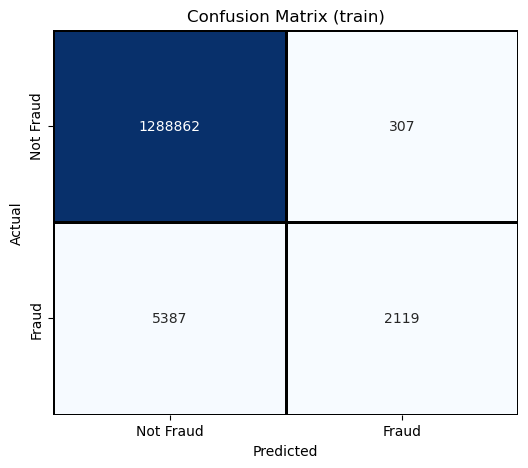

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_70723/1336632771.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


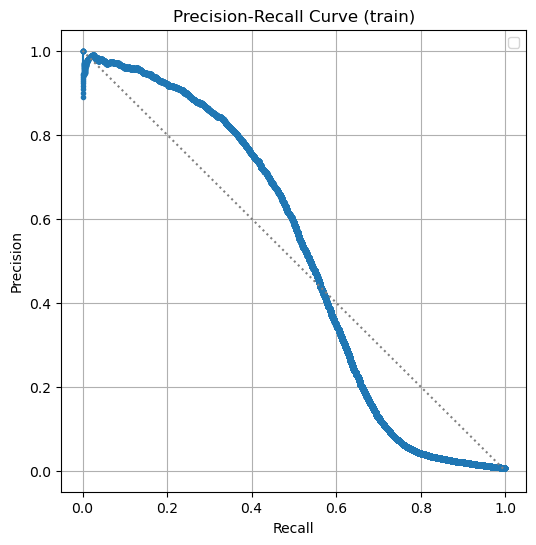

Test set:
PR AUC score: 0.4328
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.81      0.27      0.40      2145

    accuracy                           1.00    555719
   macro avg       0.90      0.63      0.70    555719
weighted avg       1.00      1.00      1.00    555719



<Figure size 600x500 with 0 Axes>

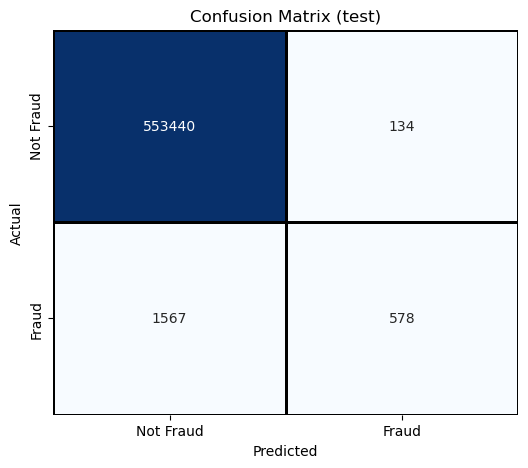

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_70723/1336632771.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


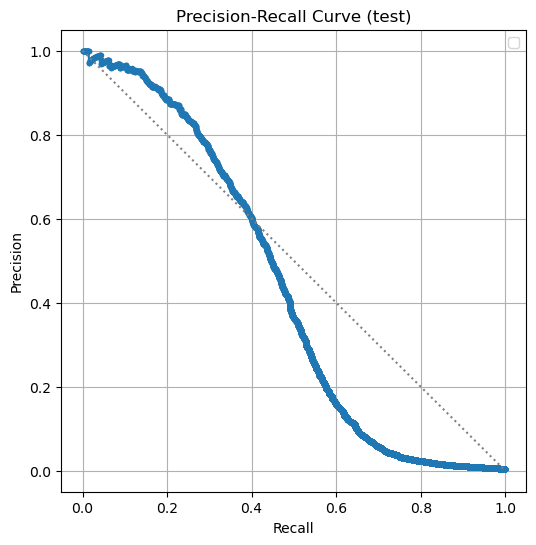

In [101]:
logreg = LogisticRegression(class_weight={0: 1, 1: 1}, random_state=4288)
logreg.fit(X_train, y_train_lr)
threshold = 0.5

y_train_probs_lr = logreg.predict_proba(X_train)[:, 1]
y_test_probs_lr = logreg.predict_proba(X_test)[:, 1]

produce_metrics(y_train_probs_lr, y_train_lr, threshold, train=True)
produce_metrics(y_test_probs_lr, y_test_lr, threshold, train=False)

## MLP

In [ ]:
class MLP_row(nn.Module):
    def __init__(self, input_dim):
        super(MLP_row, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.mlp(x)

    def compute_loss(self, y_prob, y_true):
        loss_fn = nn.BCELoss()
        return loss_fn(y_prob, y_true)

def train(model, x, y_true, optimizer, num_epochs):
    losses = []
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        y_probs = torch.sigmoid(model(x)).squeeze() # get probabilities
        loss = model.compute_loss(y_probs, y_true)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch + 1) % max(1, num_epochs // 10) == 0:
            print(f"Epoch {epoch+1}, time: {(time.time()-start_time):.2f}s, Loss: {loss.item()}")
    return losses, y_probs

def test(model, x, y_true): 
    model.eval()
    with torch.no_grad():
        y_probs = torch.sigmoid(model(x)).squeeze()
        loss = model.compute_loss(y_probs, y_true)
    print(f"Test Loss: {loss.item()}")
    return loss.item(), y_probs

In [46]:
input_dim = X_train.shape[1]
num_epochs = 100
lr = 0.01
threshold = 0.5

MLP_row_model = MLP_row(input_dim)
optimizer = torch.optim.Adam(MLP_row_model.parameters(), lr=lr)

train_losses, y_train_probs = train(MLP_row_model, torch.tensor(X_train, dtype=torch.float32),
                                    torch.tensor(y_train_lr, dtype=torch.float32), optimizer, num_epochs)

test_loss, y_test_probs = test(MLP_row_model, torch.tensor(X_test, dtype=torch.float32), 
                                    torch.tensor(y_test_lr, dtype=torch.float32))

Epoch 10, time: 56.13s, Loss: 0.04174191877245903
Epoch 20, time: 102.17s, Loss: 0.026115255430340767
Epoch 30, time: 148.67s, Loss: 0.02276986837387085
Epoch 40, time: 201.87s, Loss: 0.021658752113580704
Epoch 50, time: 258.16s, Loss: 0.020621182397007942
Epoch 60, time: 314.84s, Loss: 0.01991116628050804
Epoch 70, time: 374.48s, Loss: 0.01892842911183834
Epoch 80, time: 431.31s, Loss: 0.017374152317643166
Epoch 90, time: 486.85s, Loss: 0.015316648408770561
Epoch 100, time: 552.36s, Loss: 0.013076714240014553
Test Loss: 0.01132250763475895


Training set:
PR AUC score: 0.7318
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.93      0.44      0.59      7506

    accuracy                           1.00   1296675
   macro avg       0.96      0.72      0.80   1296675
weighted avg       1.00      1.00      1.00   1296675



<Figure size 600x500 with 0 Axes>

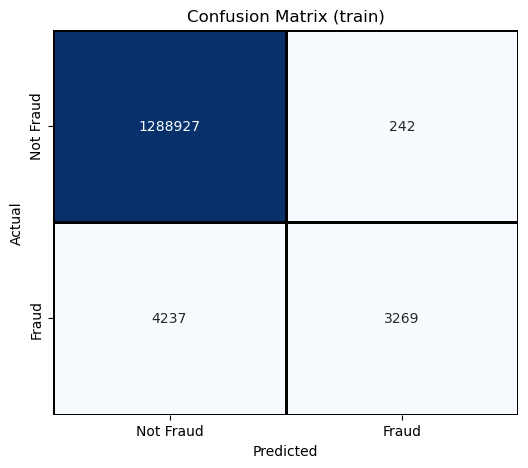

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_92923/1336632771.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


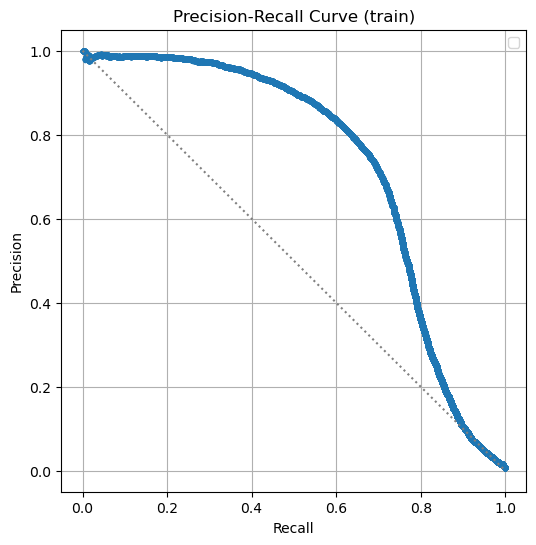

Test set:
PR AUC score: 0.5548
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.83      0.32      0.46      2145

    accuracy                           1.00    555719
   macro avg       0.91      0.66      0.73    555719
weighted avg       1.00      1.00      1.00    555719



<Figure size 600x500 with 0 Axes>

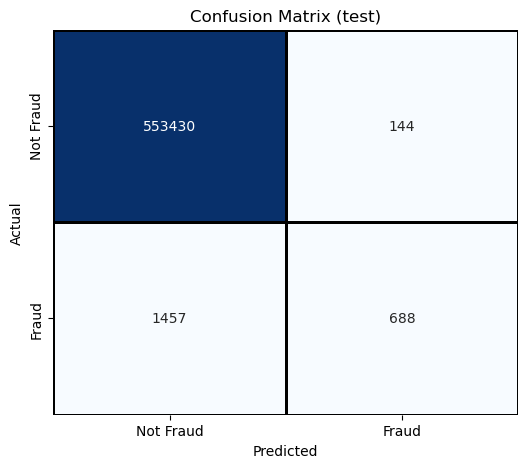

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_92923/1336632771.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


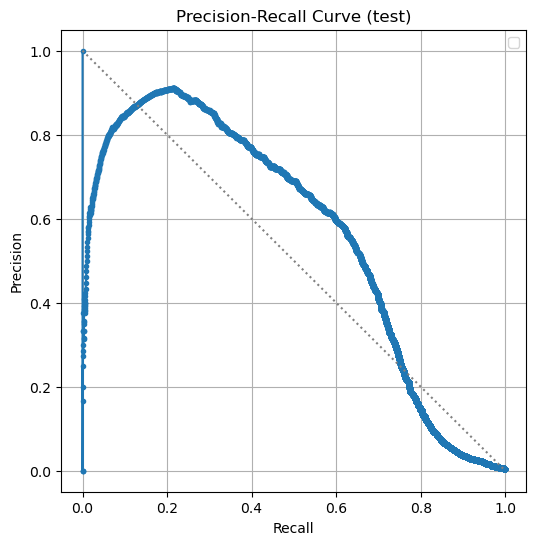

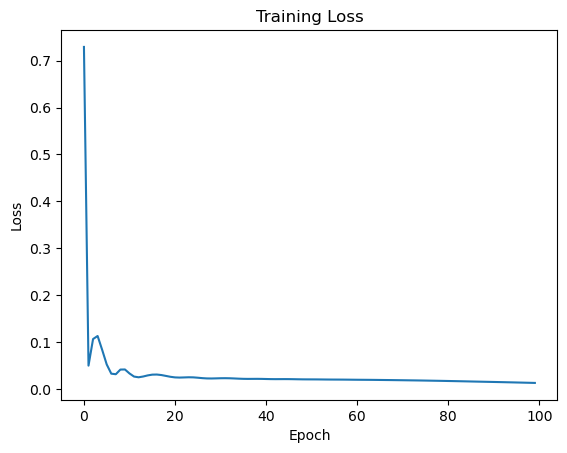

In [47]:
produce_metrics(y_train_probs.detach().cpu().numpy(), y_train_lr, threshold, train=True)
produce_metrics(y_test_probs.detach().cpu().numpy(), y_test_lr, threshold, train=False)

plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Extract Graph Features

In [76]:
# Create a OneHotEncoder for the category
category_encoder = OneHotEncoder(handle_unknown='ignore')
category_encoder.fit(fraud_train[['category']])
category_array_train = category_encoder.transform(fraud_train[['category']]).toarray()
category_array_train = category_array_train[:, :-1] # remove last column
category_array_test = category_encoder.transform(fraud_test[['category']]).toarray()
category_array_test = category_array_test[:, :-1] # remove last column

job_encoder = OneHotEncoder(handle_unknown='ignore')
job_encoder.fit(fraud_train[['job_category']])
job_array_train = job_encoder.transform(fraud_train[['job_category']]).toarray()
job_array_train = job_array_train[:, :-1] # remove last column
job_array_test = job_encoder.transform(fraud_test[['job_category']]).toarray()
job_array_test = job_array_test[:, :-1] # remove last column

# predict: is_fraud
edge_feature_names = ['count_last24h_norm', 'count_last7days_norm', 
                    'count_last30days_norm', 'past_count_with_merchant_norm',
                    'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
                    'amt_norm']

G = nx.MultiGraph()

for index, row in fraud_train.iterrows():
    customer_node = row['cc_num']
    merchant_node = row['merchant']
    trans_id = row['trans_num']
    if not G.has_node(customer_node):
        node_type = 1.0
        vector = np.concatenate([[node_type, row['gender_binary'], row['age_norm'], row['customer_degree_norm']],
                                job_array_train[index], np.zeros(category_array_train.shape[1])])
        G.add_node(customer_node, type='customer', feature_vector=vector)
    if not G.has_node(merchant_node):
        node_type = 0.0
        vector = np.concatenate([[node_type, 0.0, 0.0, row['merchant_degree_norm']],
                                np.zeros(job_array_train.shape[1]), category_array_train[index]])
        G.add_node(merchant_node, type='merchant', feature_vector=vector)
    
    edge_vector = row[edge_feature_names].values
    G.add_edge(customer_node, merchant_node, transaction_id = trans_id, is_test=0.0, is_fraud=row['is_fraud'],
                feature_vector = edge_vector)

G_test = G.copy()
for index, row in fraud_test.iterrows():
    customer_node = row['cc_num']
    merchant_node = row['merchant']
    trans_id = row['trans_num']
    if not G_test.has_node(customer_node):
        node_type = 1.0
        vector = np.concatenate([[node_type, row['gender_binary'], row['age_norm'], row['customer_degree_norm']],
                                job_array_test[index], np.zeros(category_array_test.shape[1])])
        G_test.add_node(customer_node, type='customer', feature_vector=vector)
    if not G_test.has_node(merchant_node):
        node_type = 0.0
        vector = np.concatenate([[node_type, 0.0, 0.0, row['merchant_degree_norm']],
                                np.zeros(job_array_test.shape[1]), category_array_test[index]])
        G_test.add_node(merchant_node, type='merchant', feature_vector=vector)
    
    edge_vector = row[edge_feature_names].values
    G_test.add_edge(customer_node, merchant_node, transaction_id = trans_id, is_test=1.0, is_fraud=row['is_fraud'],
                feature_vector = edge_vector)


In [77]:
def extract_graph_data(G, test=False):
    """
    Extracts node features, edge features, edge index, and fraud labels from a given NetworkX graph.
    
    Returns:
        node_features (torch.Tensor): Features of nodes.
        edge_features (torch.Tensor): Features of edges.
        edge_index (torch.Tensor): Edge connections.
        y_labels (torch.Tensor): Fraud labels for each edge.
    """
    node_list = sorted(G.nodes(), key=lambda x: str(x))  # Consistent node order
    node_idx_map = {node: i for i, node in enumerate(node_list)}  # Map node IDs to index

    node_features = np.array([G.nodes[node]['feature_vector'] for node in node_list])

    edge_index = []
    edge_features = []
    y_labels = []
    test_mask = [] # 1 for test, 0 for train

    for u, v, edge_data in G.edges(data=True):
        if G.nodes[u]['type'] == 'customer':
            customer, merchant = u, v
        else: 
            customer, merchant = v, u
        edge_index.append([node_idx_map[customer], node_idx_map[merchant]])  # Convert to indices
        edge_features.append(np.array(edge_data['feature_vector'], dtype=np.float32))  # Edge feature vector
        y_labels.append(edge_data['is_fraud'])  # Fraud label
        if test==True:
            test_mask.append(edge_data['is_test'])
        else: # train graph
            test_mask.append(edge_data['is_test'])
    
    # Convert to tensors
    node_features = torch.tensor(node_features, dtype=torch.float32)
    edge_features = torch.tensor(np.array(edge_features), dtype=torch.float32)
    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.long)  # Transpose to shape (2, num_edges)
    y_labels = torch.tensor(y_labels, dtype=torch.float32)
    test_mask = torch.tensor(test_mask, dtype=torch.float32)

    return node_features, edge_features, edge_index, y_labels, test_mask

node_features_train, edge_features_train, edge_index_train, y_train, __ = extract_graph_data(G)
node_features_test, edge_features_test, edge_index_test, y_test, test_mask = extract_graph_data(G_test)

# Output Shapes
print(f"Node Features (Train): {node_features_train.shape}")
print(f"Edge Features (Train): {edge_features_train.shape}")
print(f"Edge Index (Train): {edge_index_train.shape}")
print(f"Fraud Labels (train): {y_train.shape}")
print(f"Node Features (test): {node_features_test.shape}")
print(f"Edge Features (test): {edge_features_test.shape}")
print(f"Edge Index (test): {edge_index_test.shape}")
print(f"Fraud Labels (test): {y_test.shape}")
print(f"Test mask: {test_mask.shape}")

Node Features (Train): torch.Size([1676, 29])
Edge Features (Train): torch.Size([1296675, 10])
Edge Index (Train): torch.Size([2, 1296675])
Fraud Labels (train): torch.Size([1296675])
Node Features (test): torch.Size([1692, 29])
Edge Features (test): torch.Size([1852394, 10])
Edge Index (test): torch.Size([2, 1852394])
Fraud Labels (test): torch.Size([1852394])
Test mask: torch.Size([1852394])


## GNN (4 layers fc)

In [31]:
class NodeAggregator(MessagePassing):
    def __init__(self, node_channel, edge_channel, out_channel):
        super(NodeAggregator, self).__init__(aggr='mean') #  "Mean" aggregation.
        self.mlp = nn.Linear(2*node_channel + edge_channel, out_channel)
        
    def forward(self, node_features, aggregated_edges, edge_index):
        """calls propagate function -> which calls message, aggregate, update"""
        return self.propagate(edge_index, x=node_features, edge_attr=aggregated_edges)
    
    def message(self, x_j, x_i, edge_attr):
        """
        x_j: Features of neighboring nodes (source nodes in bipartite graph)
        x_i: Features of target nodes (destination nodes in bipartite graph)
        edge_attr: Aggregated edge features
        output: transformed message for each edge

        the aggregation takes the mean of these messages and updates representation for each node
        """
        return self.mlp(torch.cat([x_j, x_i, edge_attr], dim=-1))

class GNN_fraud_5(nn.Module):
    def __init__(self, input_dim, edge_dim, layer_dim=[64, 32, 32, 128, 512, 256, 128, 64]):
        super(GNN_fraud_5, self).__init__()

        self.node_encoder = nn.Linear(input_dim, layer_dim[0])
        self.edge_encoder = nn.Linear(edge_dim, layer_dim[1])
        self.multiedge_encoder = nn.Sequential(nn.Linear(layer_dim[1], layer_dim[2]))
        self.node_aggregator = NodeAggregator(layer_dim[0], layer_dim[2], layer_dim[3])
        self.fc = nn.Sequential(nn.Linear(layer_dim[0]*2+layer_dim[1]+layer_dim[2]+layer_dim[3]*2, layer_dim[4]),
                                nn.BatchNorm1d(layer_dim[4]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[4], layer_dim[5]),
                                nn.BatchNorm1d(layer_dim[5]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[5], layer_dim[6]),
                                nn.BatchNorm1d(layer_dim[6]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[6], layer_dim[7]),
                                nn.BatchNorm1d(layer_dim[7]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[7], 1)
                                )
        self.apply(self.init_weights)
    
    def forward(self, node_features, edge_features, edge_index):
        node_encoded = self.node_encoder(node_features)
        edge_encoded = self.edge_encoder(edge_features)

        # Aggregate edge features
        uv_pairs, edge_group_idx = edge_index.t().unique(dim=0, return_inverse=True)
        aggregated_edges = scatter_mean(edge_encoded, edge_group_idx, dim=0)
        aggregated_edges = self.multiedge_encoder(aggregated_edges)  # Apply MLP

        # Aggregate node features
        expanded_edges = aggregated_edges[edge_group_idx]  # Map back to original edge_index. Shape: (|E|, layer_dim[2])
        aggregated_nodes = self.node_aggregator(node_encoded, expanded_edges, edge_index)

        x = torch.cat([node_encoded[edge_index[0]], node_encoded[edge_index[1]], 
                       edge_encoded, expanded_edges, 
                       aggregated_nodes[edge_index[0]], aggregated_nodes[edge_index[1]]], dim=1)
        y = self.fc(x)
        return y
    
    def compute_loss(self, y_pred, y_true):
        loss_fn = nn.BCELoss()
        return loss_fn(y_pred, y_true)
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # Xavier Initialization
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.01)  # Initialize biases to small value

def train(model, node_features, edge_features, edge_index, y_true, optimizer, num_epochs):
    losses = []
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        y_probs = torch.sigmoid(model(node_features, edge_features, edge_index)).squeeze() # get probabilities
        loss = model.compute_loss(y_probs, y_true)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch + 1) % max(1, num_epochs // 10) == 0:
            print(f"Epoch {epoch+1}, time: {(time.time()-start_time):.2f}s, Loss: {loss.item()}")
    return losses, y_probs

def test(model, node_features, edge_features, edge_index, y_true, test_mask):
    test_mask = torch.tensor(test_mask, dtype=torch.bool)
    model.eval()
    with torch.no_grad():
        y_probs = torch.sigmoid(model(node_features, edge_features, edge_index)).squeeze()
        y_probs_test = y_probs[test_mask]
        y_true = y_true[test_mask]
        loss = model.compute_loss(y_probs_test, y_true)
    print(f"Test Loss: {loss.item()}")
    return loss.item(), y_probs_test

In [32]:
node_dim = node_features_train.shape[1]
edge_dim = edge_features_train.shape[1]
num_epochs = 100
lr = 0.01
threshold = 0.5

GNN_fraud_model_5 = GNN_fraud_5(node_dim, edge_dim)
optimizer = torch.optim.Adam(GNN_fraud_model_5.parameters(), lr=lr)

train_losses, y_train_probs_5 = train(GNN_fraud_model_5, node_features_train, edge_features_train, edge_index_train, y_train,
                                    optimizer, num_epochs)

Epoch 10, time: 289.97s, Loss: 0.0934380516409874
Epoch 20, time: 580.40s, Loss: 0.03252391889691353
Epoch 30, time: 878.38s, Loss: 0.0239674411714077
Epoch 40, time: 1175.38s, Loss: 0.020530063658952713
Epoch 50, time: 1477.14s, Loss: 0.01829640567302704
Epoch 60, time: 1766.89s, Loss: 0.01657818630337715
Epoch 70, time: 2071.14s, Loss: 0.015164805576205254
Epoch 80, time: 2372.13s, Loss: 0.015337671153247356
Epoch 90, time: 2665.02s, Loss: 0.015461504459381104
Epoch 100, time: 2966.82s, Loss: 0.013828134164214134


/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_92923/2757453138.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_mask = torch.tensor(test_mask, dtype=torch.bool)


Test Loss: 0.012201625853776932
Training set:
PR AUC score: 0.6939
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1289169
         1.0       0.90      0.48      0.63      7506

    accuracy                           1.00   1296675
   macro avg       0.95      0.74      0.81   1296675
weighted avg       1.00      1.00      1.00   1296675



<Figure size 600x500 with 0 Axes>

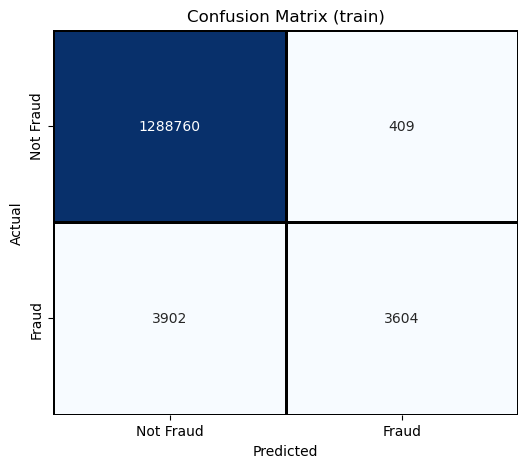

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_92923/1336632771.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


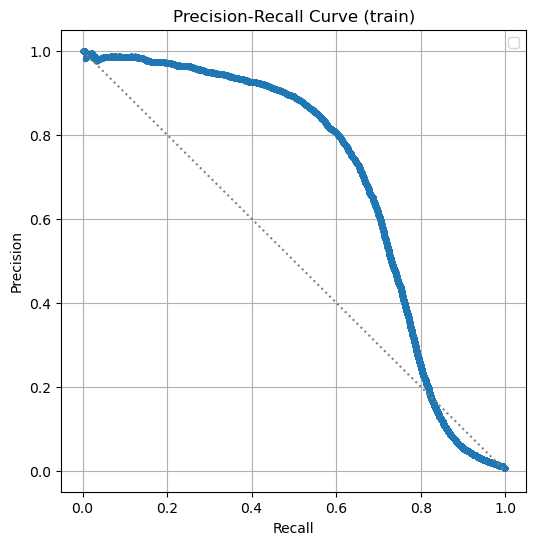

Test set:
PR AUC score: 0.5872
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    553574
         1.0       0.77      0.49      0.60      2145

    accuracy                           1.00    555719
   macro avg       0.88      0.74      0.80    555719
weighted avg       1.00      1.00      1.00    555719



<Figure size 600x500 with 0 Axes>

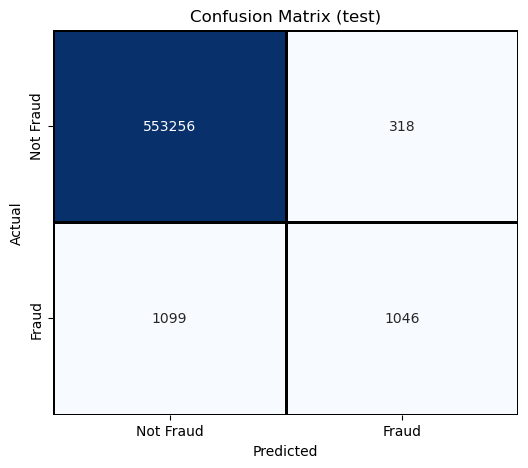

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_92923/1336632771.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


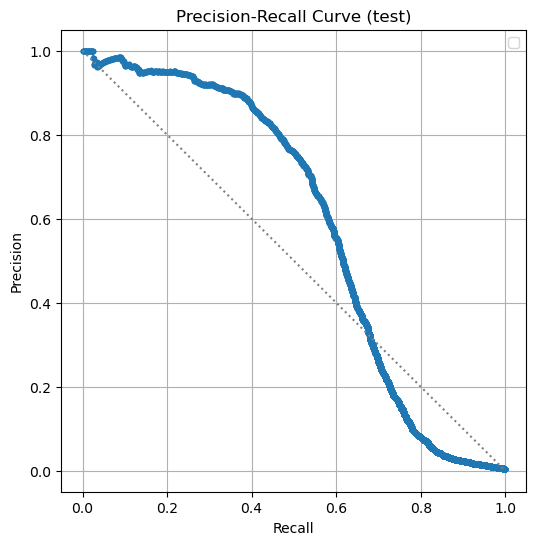

In [33]:
test_loss, y_test_probs_5 = test(GNN_fraud_model_5, node_features_test, edge_features_test, edge_index_test, y_test, test_mask)
produce_metrics(y_train_probs_5.detach().cpu().numpy(), y_train, threshold, train=True)
produce_metrics(y_test_probs_5.detach().cpu().numpy(), y_test[test_mask.bool()], threshold, train=False)

# weighted loss function {0:1, 1:5}

## logistic reg

Training set:
PR AUC score: 0.5029
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.64      0.46      0.54      7506

    accuracy                           1.00   1296675
   macro avg       0.82      0.73      0.77   1296675
weighted avg       0.99      1.00      1.00   1296675



<Figure size 600x500 with 0 Axes>

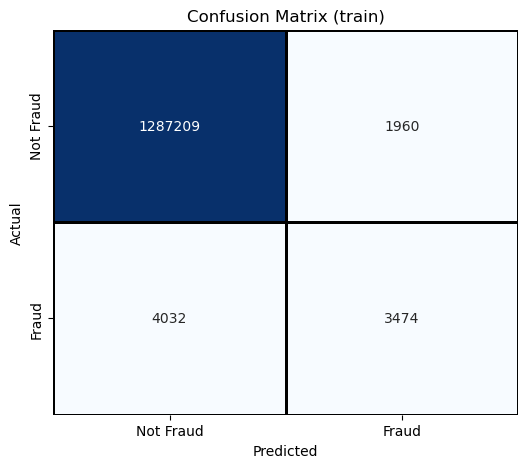

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_44843/1336632771.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


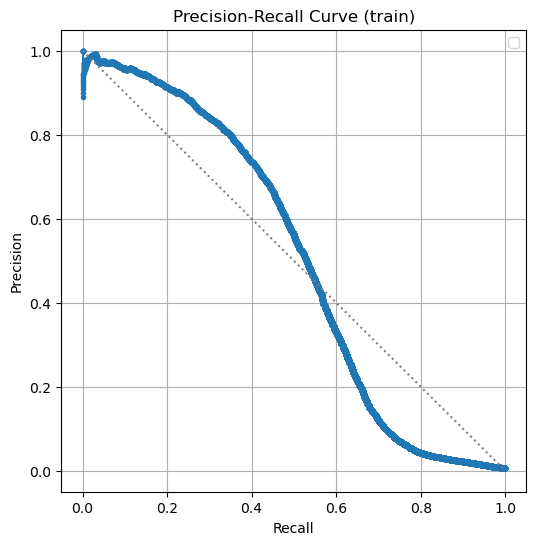

Test set:
PR AUC score: 0.4205
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.51      0.42      0.46      2145

    accuracy                           1.00    555719
   macro avg       0.76      0.71      0.73    555719
weighted avg       1.00      1.00      1.00    555719



<Figure size 600x500 with 0 Axes>

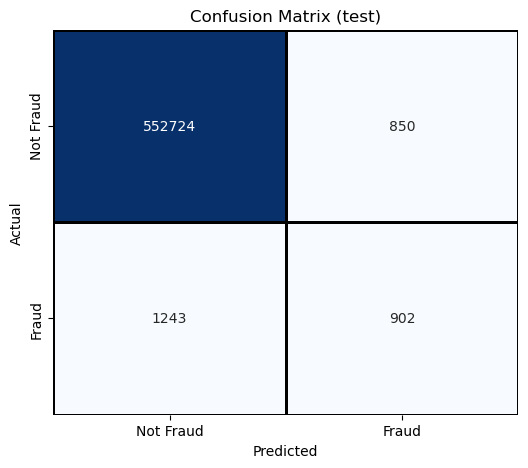

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_44843/1336632771.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


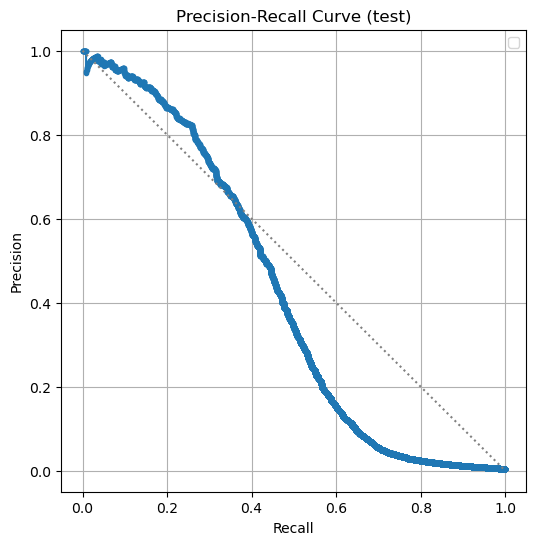

In [28]:
logreg = LogisticRegression(class_weight={0: 1, 1: 5}, random_state=4288)
logreg.fit(X_train, y_train_lr)
threshold = 0.5

y_train_probs_lr = logreg.predict_proba(X_train)[:, 1]
y_test_probs_lr = logreg.predict_proba(X_test)[:, 1]

produce_metrics(y_train_probs_lr, y_train_lr, threshold, train=True)
produce_metrics(y_test_probs_lr, y_test_lr, threshold, train=False)

## MLP

In [33]:
class MLP_row_3(nn.Module):
    def __init__(self, input_dim, loss_weights=None):
        super(MLP_row_3, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 1)
        )
        self.loss_weights = loss_weights
    
    def forward(self, x):
        return self.mlp(x)

    def compute_loss(self, y_prob, y_true):
        if self.loss_weights:
            weights_vector = torch.tensor([1.0 if label == 0 else self.loss_weights for label in y_true], dtype=torch.float32)
            loss_fn = nn.BCELoss(weight=weights_vector)
        else:
            loss_fn = nn.BCELoss()
        return loss_fn(y_prob, y_true)

def train(model, x, y_true, optimizer, num_epochs):
    losses = []
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        y_probs = torch.sigmoid(model(x)).squeeze() # get probabilities
        loss = model.compute_loss(y_probs, y_true)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch + 1) % max(1, num_epochs // 10) == 0:
            print(f"Epoch {epoch+1}, time: {(time.time()-start_time):.2f}s, Loss: {loss.item()}")
    return losses, y_probs

def test(model, x, y_true): 
    model.eval()
    with torch.no_grad():
        y_probs = torch.sigmoid(model(x)).squeeze()
        loss = model.compute_loss(y_probs, y_true)
    print(f"Test Loss: {loss.item()}")
    return loss.item(), y_probs

In [24]:
input_dim = X_train.shape[1]
num_epochs = 100
lr = 0.01
threshold = 0.5

MLP_row_model_3 = MLP_row_3(input_dim, loss_weights=5.0)
optimizer = torch.optim.Adam(MLP_row_model_3.parameters(), lr=lr)

train_losses, y_train_probs = train(MLP_row_model_3, torch.tensor(X_train, dtype=torch.float32),
                                    torch.tensor(y_train_lr, dtype=torch.float32), optimizer, num_epochs)

test_loss, y_test_probs = test(MLP_row_model_3, torch.tensor(X_test, dtype=torch.float32), 
                                    torch.tensor(y_test_lr, dtype=torch.float32))

Epoch 10, time: 703.51s, Loss: 0.11615992337465286
Epoch 20, time: 1269.06s, Loss: 0.04825331270694733
Epoch 30, time: 1825.24s, Loss: 0.02944495715200901
Epoch 40, time: 2367.25s, Loss: 0.022544998675584793
Epoch 50, time: 2924.51s, Loss: 0.018370380625128746
Epoch 60, time: 3472.47s, Loss: 0.015600536949932575
Epoch 70, time: 4032.85s, Loss: 0.014640114270150661
Epoch 80, time: 4629.49s, Loss: 0.012255582958459854
Epoch 90, time: 5252.26s, Loss: 0.012748673558235168
Epoch 100, time: 5850.95s, Loss: 0.017185352742671967
Test Loss: 0.08009263128042221


Training set:
PR AUC score: 0.9007
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.58      0.92      0.71      7506

    accuracy                           1.00   1296675
   macro avg       0.79      0.96      0.86   1296675
weighted avg       1.00      1.00      1.00   1296675



<Figure size 600x500 with 0 Axes>

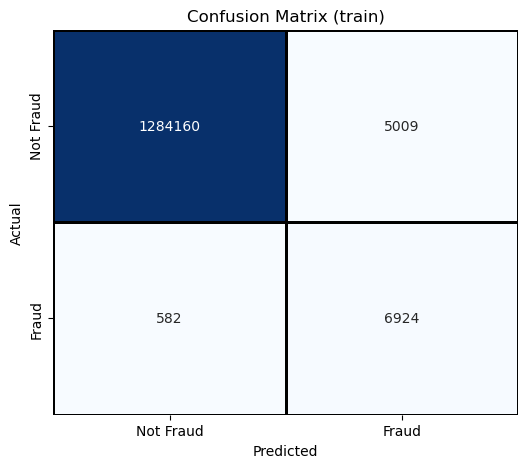

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_57437/1336632771.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


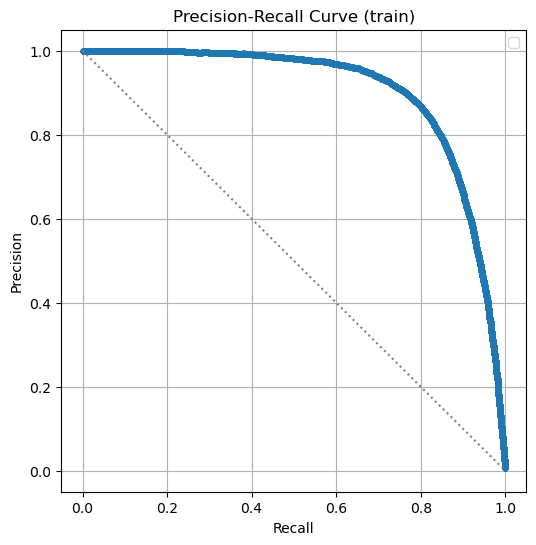

Test set:
PR AUC score: 0.7108
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    553574
           1       0.11      0.91      0.20      2145

    accuracy                           0.97    555719
   macro avg       0.55      0.94      0.59    555719
weighted avg       1.00      0.97      0.98    555719



<Figure size 600x500 with 0 Axes>

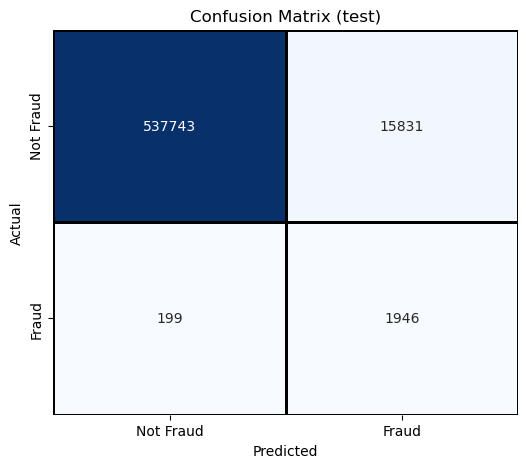

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_57437/1336632771.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


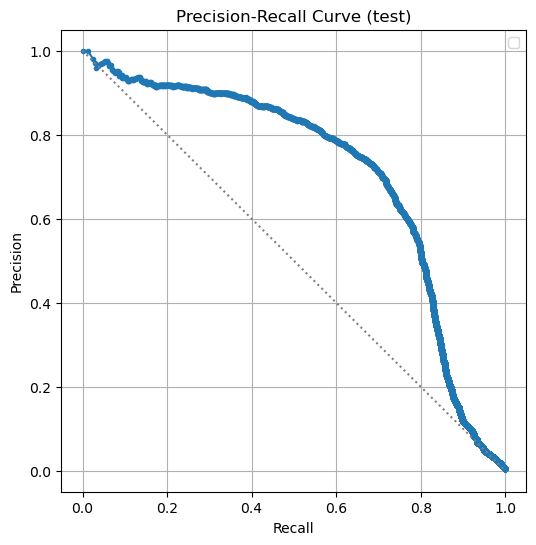

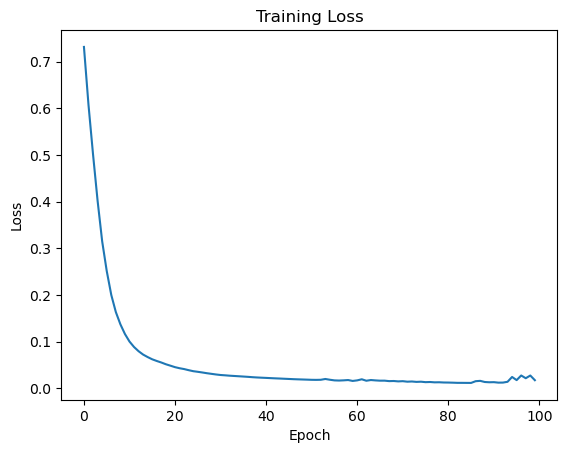

In [25]:
produce_metrics(y_train_probs.detach().cpu().numpy(), y_train_lr, threshold, train=True)
produce_metrics(y_test_probs.detach().cpu().numpy(), y_test_lr, threshold, train=False)

plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## GNN 1-hop

In [ ]:
# one-hop
class NodeAggregator(MessagePassing):
    def __init__(self, node_channel, edge_channel, out_channel):
        super(NodeAggregator, self).__init__(aggr='mean') #  "Mean" aggregation.
        self.mlp = nn.Linear(2*node_channel + edge_channel, out_channel)
        
    def forward(self, node_features, aggregated_edges, edge_index):
        """calls propagate function -> which calls message, aggregate, update"""
        return self.propagate(edge_index, x=node_features, edge_attr=aggregated_edges)
    
    def message(self, x_j, x_i, edge_attr):
        """
        x_j: Features of neighboring nodes (source nodes in bipartite graph)
        x_i: Features of target nodes (destination nodes in bipartite graph)
        edge_attr: Aggregated edge features
        output: transformed message for each edge

        the aggregation takes the mean of these messages and updates representation for each node
        """
        return self.mlp(torch.cat([x_j, x_i, edge_attr], dim=-1))

class GNN_fraud_5_weighted_loss(nn.Module):
    def __init__(self, input_dim, edge_dim, layer_dim=[64, 32, 32, 128, 512, 256, 128, 128, 128, 128, 128, 64], loss_weights=None):
        super(GNN_fraud_5_weighted_loss, self).__init__()

        self.node_encoder = nn.Linear(input_dim, layer_dim[0])
        self.edge_encoder = nn.Linear(edge_dim, layer_dim[1])
        self.multiedge_encoder = nn.Sequential(nn.Linear(layer_dim[1], layer_dim[2]))
        self.node_aggregator = NodeAggregator(layer_dim[0], layer_dim[2], layer_dim[3])
        self.fc = nn.Sequential(nn.Linear(layer_dim[0]*2+layer_dim[1]+layer_dim[2]+layer_dim[3]*2, layer_dim[4]),
                                nn.BatchNorm1d(layer_dim[4]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[4], layer_dim[5]),
                                nn.BatchNorm1d(layer_dim[5]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[5], layer_dim[6]),
                                nn.BatchNorm1d(layer_dim[6]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[6], layer_dim[7]),
                                nn.BatchNorm1d(layer_dim[7]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[7], layer_dim[8]),
                                nn.BatchNorm1d(layer_dim[8]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[8], layer_dim[9]),
                                nn.BatchNorm1d(layer_dim[9]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[9], layer_dim[10]),
                                nn.BatchNorm1d(layer_dim[10]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[10], layer_dim[11]),
                                nn.BatchNorm1d(layer_dim[11]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[11], 1)
                                )
        self.loss_weights = loss_weights
        self.apply(self.init_weights)
    
    def forward(self, node_features, edge_features, edge_index):
        node_encoded = self.node_encoder(node_features)
        edge_encoded = self.edge_encoder(edge_features)

        # Aggregate edge features
        uv_pairs, edge_group_idx = edge_index.t().unique(dim=0, return_inverse=True)
        aggregated_edges = scatter_mean(edge_encoded, edge_group_idx, dim=0)
        aggregated_edges = self.multiedge_encoder(aggregated_edges)  # Apply MLP

        # Aggregate node features
        expanded_edges = aggregated_edges[edge_group_idx]  # Map back to original edge_index. Shape: (|E|, layer_dim[2])
        aggregated_nodes = self.node_aggregator(node_encoded, expanded_edges, edge_index)

        x = torch.cat([node_encoded[edge_index[0]], node_encoded[edge_index[1]], 
                       edge_encoded, expanded_edges, 
                       aggregated_nodes[edge_index[0]], aggregated_nodes[edge_index[1]]], dim=1)
        y = self.fc(x)
        return y
    
    def compute_loss(self, y_pred, y_true):
        if self.loss_weights:
            weights_vector = torch.tensor([1.0 if label == 0 else self.loss_weights for label in y_true], dtype=torch.float32)
            loss_fn = nn.BCELoss(weight=weights_vector)
        else: 
            loss_fn = nn.BCELoss()
        return loss_fn(y_pred, y_true)
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # Xavier Initialization
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.01)  # Initialize biases to small value

def train(model, node_features_train, edge_features_train, edge_index_train, y_true_train, 
          node_features_test, edge_features_test, edge_index_test, y_true_test, test_mask, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    start_time = time.time()
    test_mask = torch.tensor(test_mask, dtype=torch.bool)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        y_probs_train = torch.sigmoid(model(node_features_train, edge_features_train, edge_index_train)).squeeze() # get probabilities
        loss = model.compute_loss(y_probs_train, y_true_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            y_probs_test = torch.sigmoid(model(node_features_test, edge_features_test, edge_index_test)).squeeze()
            y_probs_test = y_probs_test[test_mask]
            y_true_test1 = y_true_test[test_mask]
            test_loss = model.compute_loss(y_probs_test, y_true_test1).item()
            test_losses.append(test_loss)

        if (epoch + 1) % max(1, num_epochs // 10) == 0:
            print(f"Epoch {epoch+1}, time: {(time.time()-start_time):.2f}s, Loss: {loss.item()}")
    return train_losses, test_losses, y_probs_train, y_probs_test

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_57437/1832732176.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_mask = torch.tensor(test_mask, dtype=torch.bool)


Epoch 10, time: 990.84s, Loss: 0.09560203552246094
Epoch 20, time: 1967.95s, Loss: 0.05376389995217323
Epoch 30, time: 2836.85s, Loss: 0.041699815541505814
Epoch 40, time: 3698.38s, Loss: 0.03357917442917824
Epoch 50, time: 4602.31s, Loss: 0.027119848877191544
Epoch 60, time: 5487.77s, Loss: 0.0229375921189785
Epoch 70, time: 6325.59s, Loss: 0.02074107900261879
Epoch 80, time: 7199.72s, Loss: 0.01897374726831913
Epoch 90, time: 8085.98s, Loss: 0.01680818386375904
Epoch 100, time: 8954.42s, Loss: 0.014872938394546509
Training set:
PR AUC score: 0.9183
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1289169
         1.0       0.81      0.88      0.84      7506

    accuracy                           1.00   1296675
   macro avg       0.90      0.94      0.92   1296675
weighted avg       1.00      1.00      1.00   1296675



<Figure size 600x500 with 0 Axes>

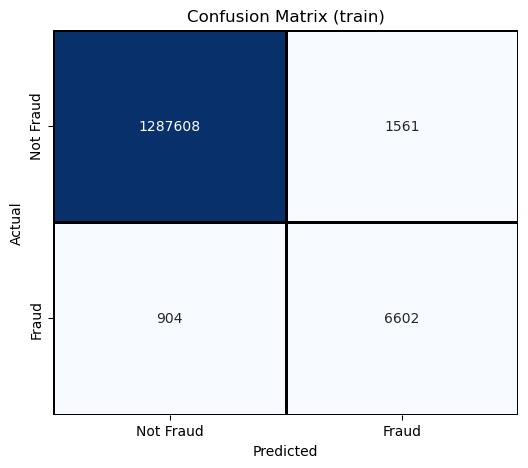

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_57437/1647992284.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


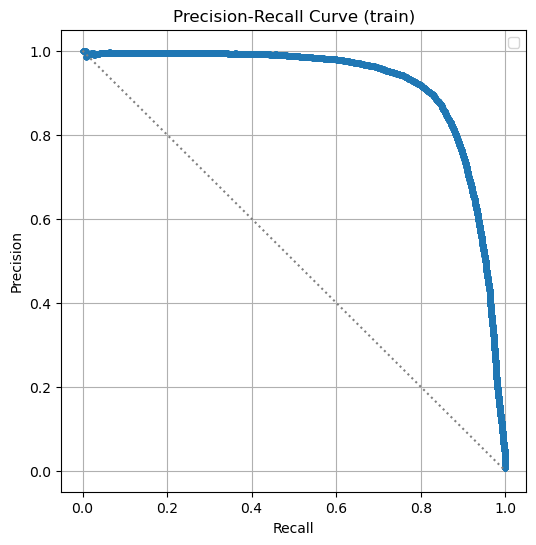

Test set:
PR AUC score: 0.8057
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    553574
         1.0       0.80      0.73      0.76      2145

    accuracy                           1.00    555719
   macro avg       0.90      0.86      0.88    555719
weighted avg       1.00      1.00      1.00    555719



<Figure size 600x500 with 0 Axes>

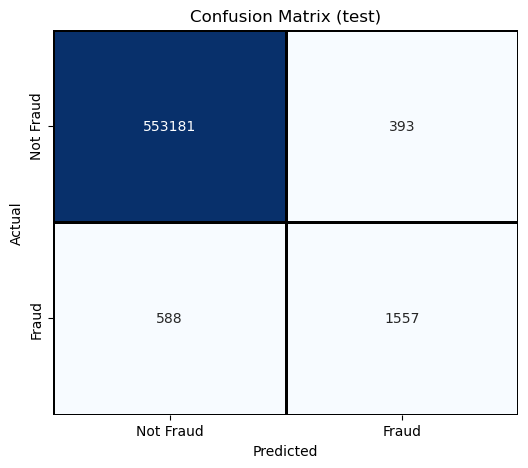

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_57437/1647992284.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


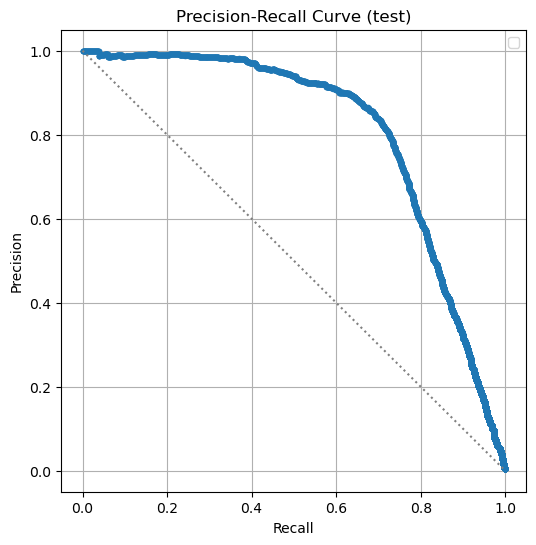

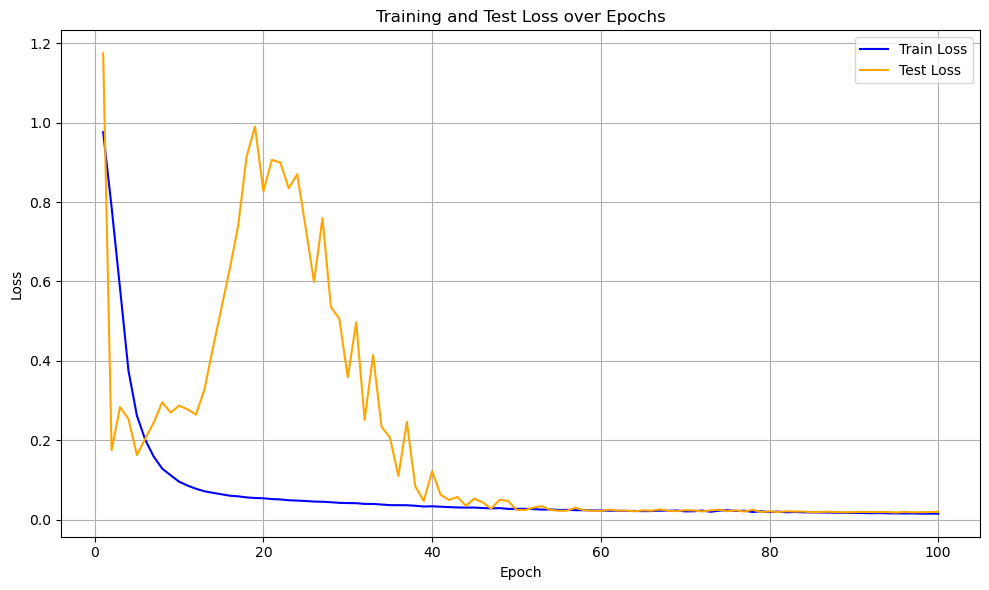

In [79]:
# one-hop
node_dim = node_features_train.shape[1]
edge_dim = edge_features_train.shape[1]
num_epochs = 100
lr = 0.01
threshold = 0.5

GNN_fraud_model_6 = GNN_fraud_5_weighted_loss(node_dim, edge_dim, loss_weights=5.0)
optimizer = torch.optim.Adam(GNN_fraud_model_6.parameters(), lr=lr)

train_losses, test_losses, y_train_probs_6, y_test_probs_6 = train(GNN_fraud_model_6, node_features_train, edge_features_train, edge_index_train, y_train,
                                    node_features_test, edge_features_test, edge_index_test, y_test, test_mask,
                                    optimizer, num_epochs)
produce_metrics(y_train_probs_6.detach().cpu().numpy(), y_train, threshold, train=True)
produce_metrics(y_test_probs_6.detach().cpu().numpy(), y_test[test_mask.bool()], threshold, train=False)

plot_train_test_losses(train_losses, test_losses)

## GNN, 2-hop

In [ ]:
# two-hop
class NodeAggregator(MessagePassing):
    def __init__(self, node_channel, edge_channel, out_channel):
        super(NodeAggregator, self).__init__(aggr='mean') #  "Mean" aggregation.
        self.mlp = nn.Linear(2*node_channel + edge_channel, out_channel)
        
    def forward(self, node_features, aggregated_edges, edge_index):
        """calls propagate function -> which calls message, aggregate, update"""
        return self.propagate(edge_index, x=node_features, edge_attr=aggregated_edges)
    
    def message(self, x_j, x_i, edge_attr):
        """
        x_j: Features of neighboring nodes (source nodes in bipartite graph)
        x_i: Features of target nodes (destination nodes in bipartite graph)
        edge_attr: Aggregated edge features
        output: transformed message for each edge

        the aggregation takes the mean of these messages and updates representation for each node
        """
        return self.mlp(torch.cat([x_j, x_i, edge_attr], dim=-1))

class GNN_fraud_6_weighted_loss(nn.Module):
    def __init__(self, input_dim, edge_dim, layer_dim=[64, 32, 32, 128, 512, 256, 128, 128, 128, 128, 128, 64], loss_weights=None):
        super(GNN_fraud_6_weighted_loss, self).__init__()

        self.node_encoder = nn.Linear(input_dim, layer_dim[0])
        self.edge_encoder = nn.Linear(edge_dim, layer_dim[1])
        self.multiedge_encoder = nn.Sequential(nn.Linear(layer_dim[1], layer_dim[2]))
        self.node_aggregator = NodeAggregator(layer_dim[0], layer_dim[2], layer_dim[3])
        self.gcn1 = GCNConv(layer_dim[3], layer_dim[3])
        self.fc = nn.Sequential(nn.Linear(layer_dim[0]*2+layer_dim[1]+layer_dim[2]+layer_dim[3]*2+layer_dim[3]*2, layer_dim[4]),
                                nn.BatchNorm1d(layer_dim[4]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[4], layer_dim[5]),
                                nn.BatchNorm1d(layer_dim[5]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[5], layer_dim[6]),
                                nn.BatchNorm1d(layer_dim[6]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[6], layer_dim[7]),
                                nn.BatchNorm1d(layer_dim[7]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[7], layer_dim[8]),
                                nn.BatchNorm1d(layer_dim[8]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[8], layer_dim[9]),
                                nn.BatchNorm1d(layer_dim[9]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[9], layer_dim[10]),
                                nn.BatchNorm1d(layer_dim[10]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[10], layer_dim[11]),
                                nn.BatchNorm1d(layer_dim[11]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[11], 1)
                                )
        self.loss_weights = loss_weights
        self.apply(self.init_weights)
    
    def forward(self, node_features, edge_features, edge_index):
        node_encoded = self.node_encoder(node_features)
        edge_encoded = self.edge_encoder(edge_features)

        # Aggregate edge features
        uv_pairs, edge_group_idx = edge_index.t().unique(dim=0, return_inverse=True)
        aggregated_edges = scatter_mean(edge_encoded, edge_group_idx, dim=0)
        aggregated_edges = self.multiedge_encoder(aggregated_edges)  # Apply MLP

        # Aggregate node features
        expanded_edges = aggregated_edges[edge_group_idx]  # Map back to original edge_index. Shape: (|E|, layer_dim[2])
        aggregated_nodes = self.node_aggregator(node_encoded, expanded_edges, edge_index)

        # Aggregate neighbourhood information
        neighbourhood = self.gcn1(aggregated_nodes, uv_pairs.t())
        x = torch.cat([node_encoded[edge_index[0]], node_encoded[edge_index[1]], 
                       edge_encoded, expanded_edges, 
                       aggregated_nodes[edge_index[0]], aggregated_nodes[edge_index[1]],
                       neighbourhood[edge_index[0]], neighbourhood[edge_index[1]]], dim=1)
        y = self.fc(x)
        return y
    
    def compute_loss(self, y_pred, y_true):
        if self.loss_weights:
            weights_vector = torch.tensor([1.0 if label == 0 else self.loss_weights for label in y_true], dtype=torch.float32)
        loss_fn = nn.BCELoss(weight=weights_vector)
        return loss_fn(y_pred, y_true)
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # Xavier Initialization
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.01)  # Initialize biases to small value

def train(model, node_features_train, edge_features_train, edge_index_train, y_true_train, 
          node_features_test, edge_features_test, edge_index_test, y_true_test, test_mask, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    start_time = time.time()
    test_mask = torch.tensor(test_mask, dtype=torch.bool)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        y_probs_train = torch.sigmoid(model(node_features_train, edge_features_train, edge_index_train)).squeeze() # get probabilities
        loss = model.compute_loss(y_probs_train, y_true_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            y_probs_test = torch.sigmoid(model(node_features_test, edge_features_test, edge_index_test)).squeeze()
            y_probs_test = y_probs_test[test_mask]
            y_true_test1 = y_true_test[test_mask]
            test_loss = model.compute_loss(y_probs_test, y_true_test1).item()
            test_losses.append(test_loss)

        if (epoch + 1) % max(1, num_epochs // 10) == 0:
            print(f"Epoch {epoch+1}, time: {(time.time()-start_time):.2f}s, Loss: {loss.item()}")
    return train_losses, test_losses, y_probs_train, y_probs_test

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_57437/48094901.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_mask = torch.tensor(test_mask, dtype=torch.bool)


Epoch 10, time: 1216.15s, Loss: 0.11118326336145401
Epoch 20, time: 2333.85s, Loss: 0.058055855333805084
Epoch 30, time: 3437.02s, Loss: 0.04342487081885338
Epoch 40, time: 5823.56s, Loss: 0.03329944983124733
Epoch 50, time: 6877.06s, Loss: 0.026883941143751144
Epoch 60, time: 9391.74s, Loss: 0.022849751636385918
Epoch 70, time: 10450.07s, Loss: 0.01976717635989189
Epoch 80, time: 12327.60s, Loss: 0.03681051731109619
Epoch 90, time: 13410.04s, Loss: 0.02713434398174286
Epoch 100, time: 14523.62s, Loss: 0.022174639627337456
Training set:
PR AUC score: 0.8317
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1289169
         1.0       0.70      0.83      0.76      7506

    accuracy                           1.00   1296675
   macro avg       0.85      0.91      0.88   1296675
weighted avg       1.00      1.00      1.00   1296675



<Figure size 600x500 with 0 Axes>

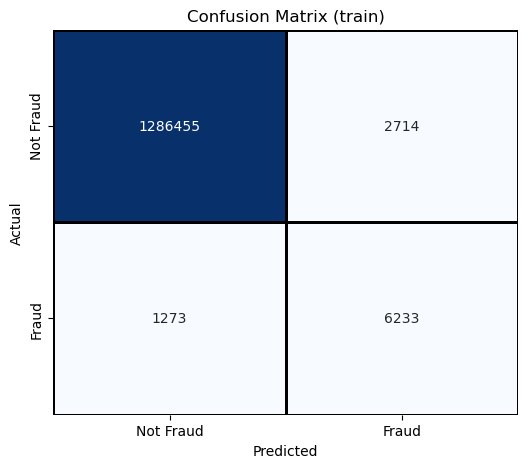

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_57437/1647992284.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


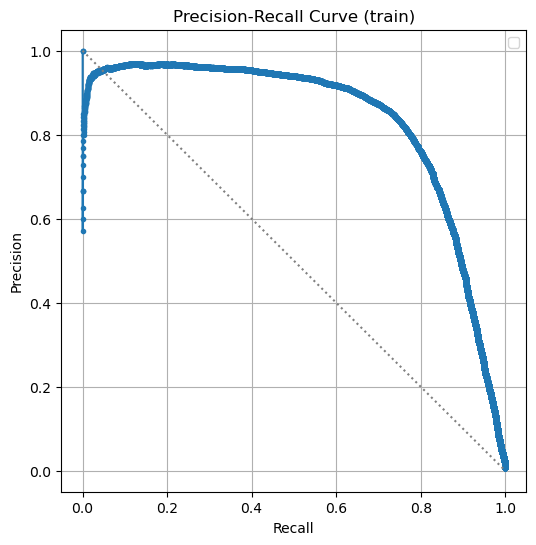

Test set:
PR AUC score: 0.6744
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    553574
         1.0       0.36      0.81      0.49      2145

    accuracy                           0.99    555719
   macro avg       0.68      0.90      0.74    555719
weighted avg       1.00      0.99      0.99    555719



<Figure size 600x500 with 0 Axes>

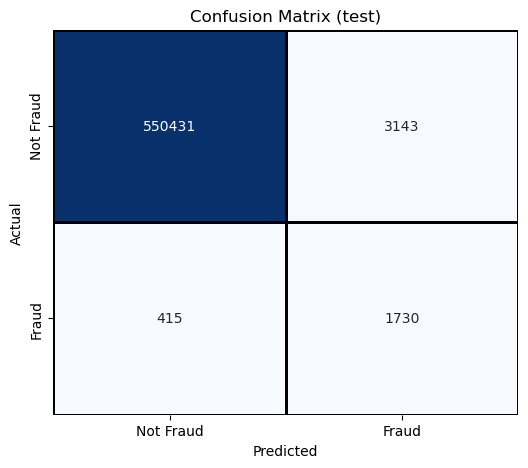

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_57437/1647992284.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


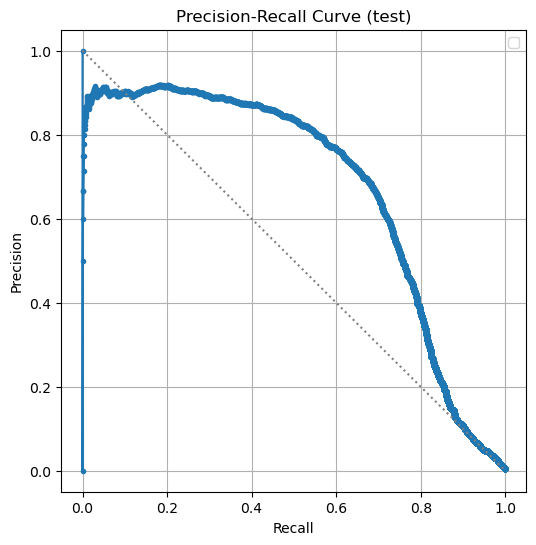

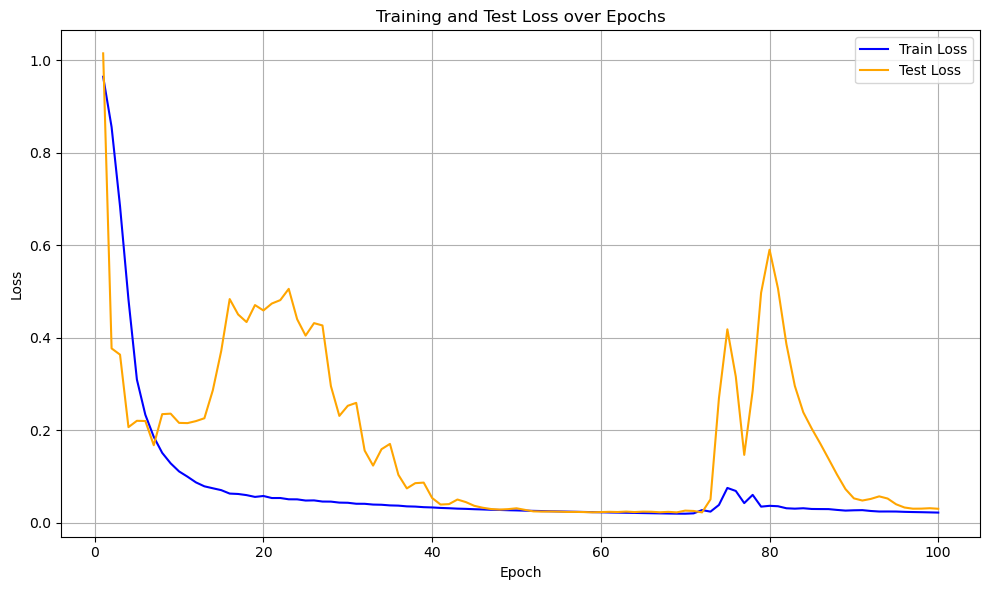

In [81]:
node_dim = node_features_train.shape[1]
edge_dim = edge_features_train.shape[1]
num_epochs = 100
lr = 0.01
threshold = 0.5

GNN_fraud_model_7 = GNN_fraud_6_weighted_loss(node_dim, edge_dim, loss_weights=5.0)
optimizer = torch.optim.Adam(GNN_fraud_model_7.parameters(), lr=lr)

train_losses, test_losses, y_train_probs_7, y_test_probs_7 = train(GNN_fraud_model_7, node_features_train, edge_features_train, edge_index_train, y_train,
                                    node_features_test, edge_features_test, edge_index_test, y_test, test_mask,
                                    optimizer, num_epochs)

produce_metrics(y_train_probs_7.detach().cpu().numpy(), y_train, threshold, train=True)
produce_metrics(y_test_probs_7.detach().cpu().numpy(), y_test[test_mask.bool()], threshold, train=False)

plot_train_test_losses(train_losses, test_losses)

## GNN 1-hop, leakyrelu at nodeaggregator

In [ ]:
# one-hop, Leaky ReLU
class NodeAggregator(MessagePassing):
    def __init__(self, node_channel, edge_channel, out_channel):
        super(NodeAggregator, self).__init__(aggr='mean') #  "Mean" aggregation.
        self.mlp = nn.Sequential(
                       nn.Linear(2*node_channel + edge_channel, out_channel),
                       nn.LeakyReLU(0.1))
        
    def forward(self, node_features, aggregated_edges, edge_index):
        """calls propagate function -> which calls message, aggregate, update"""
        return self.propagate(edge_index, x=node_features, edge_attr=aggregated_edges)
    
    def message(self, x_j, x_i, edge_attr):
        """
        x_j: Features of neighboring nodes (source nodes in bipartite graph)
        x_i: Features of target nodes (destination nodes in bipartite graph)
        edge_attr: Aggregated edge features
        output: transformed message for each edge

        the aggregation takes the mean of these messages and updates representation for each node
        """
        return self.mlp(torch.cat([x_j, x_i, edge_attr], dim=-1))

class GNN_fraud_8_weighted_loss(nn.Module):
    def __init__(self, input_dim, edge_dim, layer_dim=[64, 32, 32, 128, 512, 256, 128, 128, 128, 128, 128, 64], loss_weights=None):
        super(GNN_fraud_8_weighted_loss, self).__init__()

        self.node_encoder = nn.Linear(input_dim, layer_dim[0])
        self.edge_encoder = nn.Linear(edge_dim, layer_dim[1])
        self.multiedge_encoder = nn.Sequential(nn.Linear(layer_dim[1], layer_dim[2]))
        self.node_aggregator = NodeAggregator(layer_dim[0], layer_dim[2], layer_dim[3])
        self.fc = nn.Sequential(nn.Linear(layer_dim[0]*2+layer_dim[1]+layer_dim[2]+layer_dim[3]*2, layer_dim[4]),
                                nn.BatchNorm1d(layer_dim[4]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[4], layer_dim[5]),
                                nn.BatchNorm1d(layer_dim[5]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[5], layer_dim[6]),
                                nn.BatchNorm1d(layer_dim[6]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[6], layer_dim[7]),
                                nn.BatchNorm1d(layer_dim[7]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[7], layer_dim[8]),
                                nn.BatchNorm1d(layer_dim[8]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[8], layer_dim[9]),
                                nn.BatchNorm1d(layer_dim[9]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[9], layer_dim[10]),
                                nn.BatchNorm1d(layer_dim[10]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[10], layer_dim[11]),
                                nn.BatchNorm1d(layer_dim[11]),
                                nn.LeakyReLU(0.1),
                                nn.Linear(layer_dim[11], 1)
                                )
        self.loss_weights = loss_weights
        self.apply(self.init_weights)
    
    def forward(self, node_features, edge_features, edge_index):
        node_encoded = self.node_encoder(node_features)
        edge_encoded = self.edge_encoder(edge_features)

        # Aggregate edge features
        uv_pairs, edge_group_idx = edge_index.t().unique(dim=0, return_inverse=True)
        aggregated_edges = scatter_mean(edge_encoded, edge_group_idx, dim=0)
        aggregated_edges = self.multiedge_encoder(aggregated_edges)  # Apply MLP

        # Aggregate node features
        expanded_edges = aggregated_edges[edge_group_idx]  # Map back to original edge_index. Shape: (|E|, layer_dim[2])
        aggregated_nodes = self.node_aggregator(node_encoded, expanded_edges, edge_index)

        x = torch.cat([node_encoded[edge_index[0]], node_encoded[edge_index[1]], 
                       edge_encoded, expanded_edges, 
                       aggregated_nodes[edge_index[0]], aggregated_nodes[edge_index[1]]], dim=1)
        y = self.fc(x)
        return y
    
    def compute_loss(self, y_pred, y_true):
        if self.loss_weights:
            weights_vector = torch.tensor([1.0 if label == 0 else self.loss_weights for label in y_true], dtype=torch.float32)
            loss_fn = nn.BCELoss(weight=weights_vector)
        else: 
            loss_fn = nn.BCELoss()
        return loss_fn(y_pred, y_true)
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # Xavier Initialization
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.01)  # Initialize biases to small value

def train(model, node_features_train, edge_features_train, edge_index_train, y_true_train, 
          node_features_test, edge_features_test, edge_index_test, y_true_test, test_mask, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    start_time = time.time()
    test_mask = torch.tensor(test_mask, dtype=torch.bool)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        y_probs_train = torch.sigmoid(model(node_features_train, edge_features_train, edge_index_train)).squeeze() # get probabilities
        loss = model.compute_loss(y_probs_train, y_true_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            y_probs_test = torch.sigmoid(model(node_features_test, edge_features_test, edge_index_test)).squeeze()
            y_probs_test = y_probs_test[test_mask]
            y_true_test1 = y_true_test[test_mask]
            test_loss = model.compute_loss(y_probs_test, y_true_test1).item()
            test_losses.append(test_loss)

        if (epoch + 1) % max(1, num_epochs // 10) == 0:
            print(f"Epoch {epoch+1}, time: {(time.time()-start_time):.2f}s, Loss: {loss.item()}")
    return train_losses, test_losses, y_probs_train, y_probs_test


/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_57437/431849672.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_mask = torch.tensor(test_mask, dtype=torch.bool)


Epoch 10, time: 863.51s, Loss: 0.07683335989713669
Epoch 20, time: 1733.17s, Loss: 0.05212029069662094
Epoch 30, time: 2603.39s, Loss: 0.03631482273340225
Epoch 40, time: 3520.11s, Loss: 0.025665283203125
Epoch 50, time: 4429.44s, Loss: 0.02036079205572605
Epoch 60, time: 5324.90s, Loss: 0.017478032037615776
Epoch 70, time: 6203.89s, Loss: 0.05923045426607132
Epoch 80, time: 7095.96s, Loss: 0.03260262310504913
Epoch 90, time: 8008.25s, Loss: 0.025329966098070145
Epoch 100, time: 8890.56s, Loss: 0.021077018231153488
Training set:
PR AUC score: 0.8033
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1289169
         1.0       0.67      0.85      0.75      7506

    accuracy                           1.00   1296675
   macro avg       0.83      0.92      0.87   1296675
weighted avg       1.00      1.00      1.00   1296675



<Figure size 600x500 with 0 Axes>

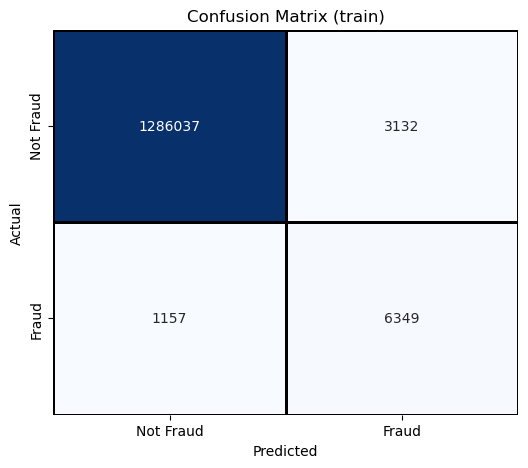

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_57437/1647992284.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


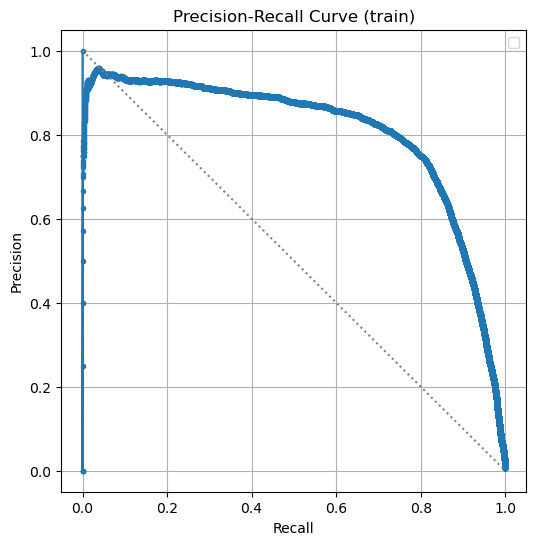

Test set:
PR AUC score: 0.7046
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    553574
         1.0       0.49      0.80      0.61      2145

    accuracy                           1.00    555719
   macro avg       0.75      0.90      0.80    555719
weighted avg       1.00      1.00      1.00    555719



<Figure size 600x500 with 0 Axes>

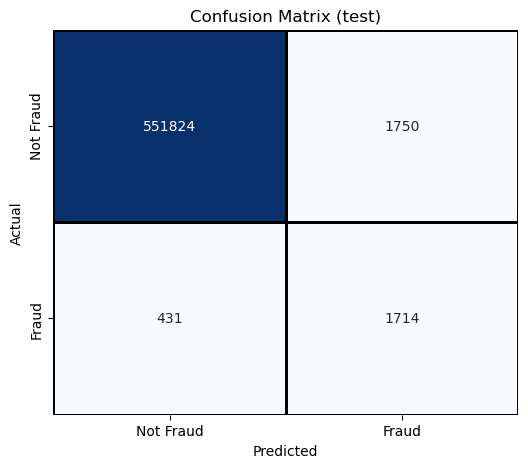

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_57437/1647992284.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


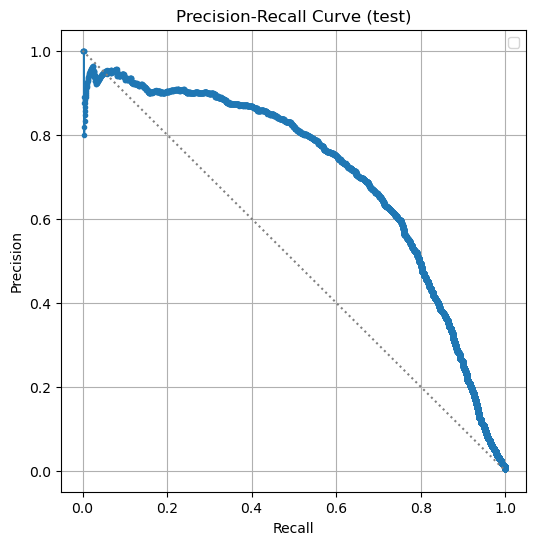

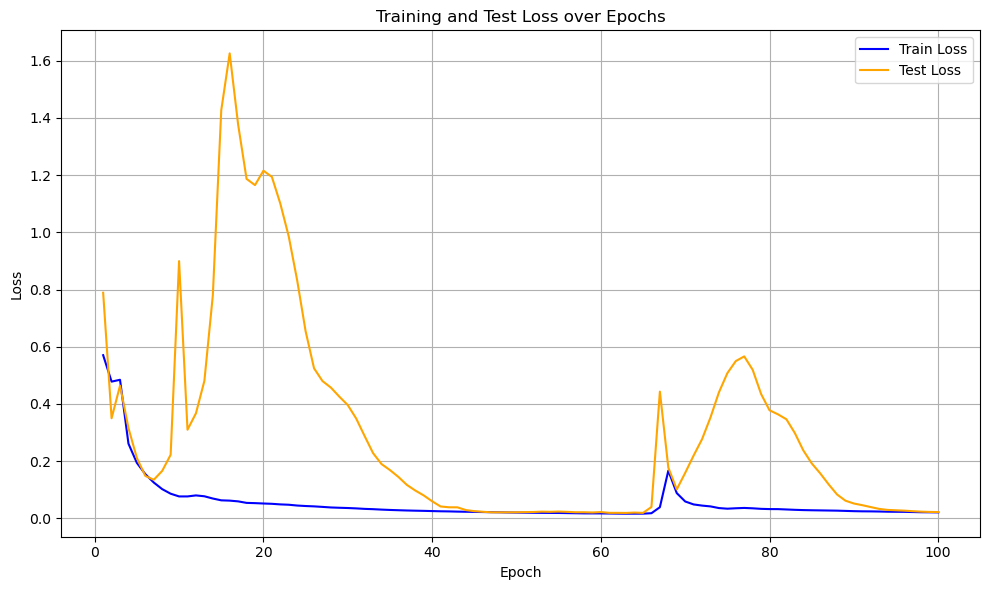

In [102]:
node_dim = node_features_train.shape[1]
edge_dim = edge_features_train.shape[1]
num_epochs = 100
lr = 0.01
threshold = 0.5

GNN_fraud_model_8 = GNN_fraud_8_weighted_loss(node_dim, edge_dim, loss_weights=5.0)
optimizer = torch.optim.Adam(GNN_fraud_model_8.parameters(), lr=lr)

train_losses, test_losses, y_train_probs_8, y_test_probs_8 = train(GNN_fraud_model_8, node_features_train, edge_features_train, edge_index_train, y_train,
                                    node_features_test, edge_features_test, edge_index_test, y_test, test_mask,
                                    optimizer, num_epochs)

produce_metrics(y_train_probs_8.detach().cpu().numpy(), y_train, threshold, train=True)
produce_metrics(y_test_probs_8.detach().cpu().numpy(), y_test[test_mask.bool()], threshold, train=False)

plot_train_test_losses(train_losses, test_losses)